In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from utils_machine_learning import *

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [2]:
# load the dataset
def load_dataset() -> pd.DataFrame:
    """
    Load the dataset from the CSV file and return it as a pandas DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: The dataset loaded from the CSV file.
    """

    data_path = "https://github.com/donadviser/datasets/raw/master/data-don/marketing_campaign.zip"
    data = pd.read_csv(data_path, compression='zip', sep="\t")
    return data

In [7]:
data_raw = load_dataset()
data_raw.to_csv("marketing_campaign_raw_data.csv", sep='\t')
data_raw.shape

(2240, 29)

In [17]:
drop_cols = [
    "i_d", "kidhome", "teenhome", "marital_status",
    "year_birth", "dt_customer", "z_cost_contact",
    "z_revenue", "total_promo", "children"
]

education_map = {"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4}
marital_map = {"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0}

In [27]:
# Define the mapping for yes or no value
current_year = datetime.now().year  # Get the current year dynamically
today = datetime.today()
data_eda = (data_raw
            .pipe(rename_columns_to_snake_case)
            .replace({'education': education_map, "marital_status": marital_map})
            .assign(
                    dt_customer = lambda df: pd.to_datetime(df['dt_customer'], format='%d-%m-%Y'),
                    age=lambda df: current_year - df['year_birth'],  # Calculate vehicle age
                    children = lambda df: (df['kidhome'] + df['teenhome']).astype('int'), # Calculate number of children
                    family_size = lambda df: (df['marital_status']).astype('int') + df['children'] + 1, # Calculate family size
                    total_spending = lambda df: df["mnt_wines"]+ df["mnt_fruits"]+ df["mnt_meat_products"]+ df["mnt_fish_products"]+ df["mnt_sweet_products"]+ df["mnt_gold_prods"], # Calculate total
                    total_promo = lambda df: df["accepted_cmp1"]+ df["accepted_cmp2"]+ df["accepted_cmp3"]+ df["accepted_cmp4"]+ df["accepted_cmp5"],
                    days_as_customer = lambda df: (today - df['dt_customer']).dt.days,
                    offers_responded_to = lambda df: df['total_promo'] + df['response'],
                    parental_status = lambda df: np.where(df["children"] > 0, 1, 0),
                    # imputation for missing values
                    income = lambda df: df["income"].fillna(df["income"].median())
                    )
            #.assign(new_age_cat=lambda df: pd.cut(df['age'], bins=[-np.inf, 35, 55, np.inf], labels=["young", "middleage", "old"]))
            .drop(columns=drop_cols)
            # Remove columns that start with "accepted"
            .pipe(lambda df: df.drop(columns=[col for col in df.columns if col.startswith('accepted')]))
        )

In [19]:
print(f"data_eda.columns: {data_eda.columns}"
      f"\ndata_eda.shape: {data_eda.shape}")

# num_deals_purchases, num_web_purchases

data_eda.columns: Index(['education', 'income', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'complain', 'response', 'age', 'family_size', 'total_spending',
       'days_as_customer', 'offers_responded_to', 'parental_status'],
      dtype='object')
data_eda.shape: (2240, 22)


In [ ]:
cols = ["Age","Education","Marital Status","Parental Status",
        "Children","Income","Total_Spending","Days_as_Customer",
        "Recency","Wines","Fruits","Meat","Fish","Sweets","Gold",
        "Web","Catalog","Store","Discount Purchases","Total Promo",
        "NumWebVisitsMonth"]

In [28]:
data_eda['response'].unique()

array([1, 0])

In [29]:
# separate the columns into different data dtypes
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(data_eda)

Observations: 2240
Variables: 22
Categorical Columns: 6 -> ['education', 'complain', 'response', 'family_size', 'offers_responded_to', 'parental_status']
Numerical Columns: 16 -> ['income', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month', 'age', 'total_spending', 'days_as_customer']
Cardinal Columns: 0 -> []
Nominal Columns: 6 -> ['education', 'complain', 'response', 'family_size', 'offers_responded_to', 'parental_status']


In [104]:
def process_df(df, col_input=None):
  """
  returns information about the DataFrame columns.

  Args:
      df: DataFrame.

  Returns:
      A string describing the DataFrame columns and their data types.
  """
  # Get column names and data types
  columns = df.dtypes.to_dict()

  # Create the desired output string
  output = "columns:\n"
  for col, dtype in columns.items():
    #if dtype != 'occ':
    if col_input != None:
        if col in col_input:
            #output += f"  - {col}: {dtype}\n"
            output += f"  - {col}\n"
    elif dtype != 'object':
      #output += f"  - {col}: {dtype}\n"
      output += f"  - {col}\n"

  return output
formated_df_info = process_df(data_eda, numerical_cols)
print(formated_df_info)

columns:
  - recency
  - mnt_wines
  - mnt_fruits
  - mnt_fish_products
  - mnt_sweet_products
  - mnt_gold_prods
  - num_store_purchases
  - age
  - total_spending
  - days_as_customer



In [34]:
outlier_cols = []
for col in numerical_cols:
    status=check_outlier(data_eda, col)
    if status:
        outlier_cols.append(col)
        print(col, status)

income True
mnt_meat_products True
num_deals_purchases True
num_web_purchases True
num_catalog_purchases True
num_web_visits_month True


Numerical Column: income
##########################################
count      2240.000000
mean      52237.975446
std       25037.955891
min        1730.000000
5%        19101.050000
10%       24219.500000
20%       32230.000000
30%       38361.000000
40%       44944.200000
50%       51381.500000
60%       58169.600000
70%       65104.600000
80%       71634.800000
90%       79800.300000
95%       83927.000000
99%       94437.680000
max      666666.000000
Name: income, dtype: float64
##########################################


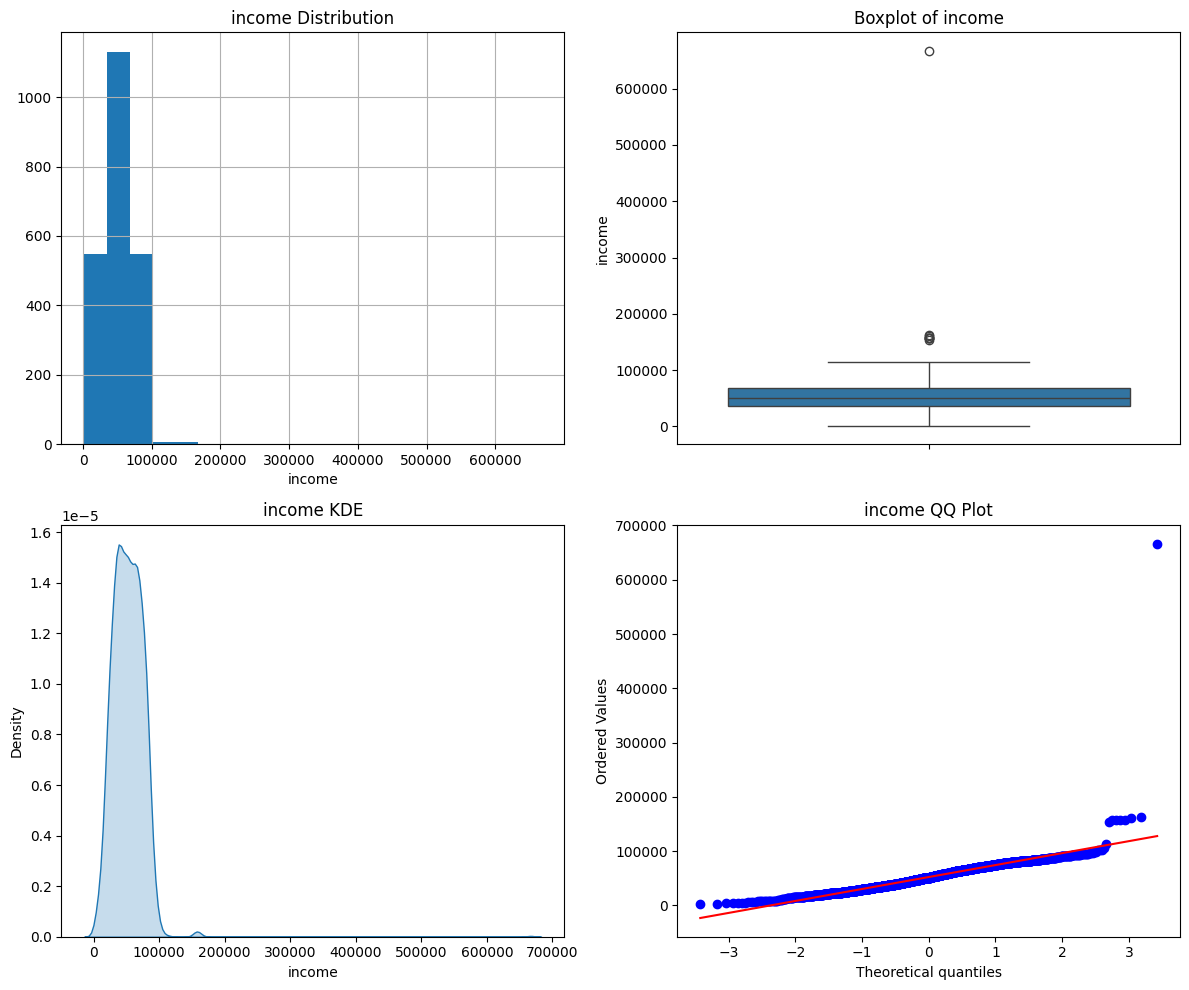

Numerical Column: recency
##########################################
count    2240.000000
mean       49.109375
std        28.962453
min         0.000000
5%          4.000000
10%         9.000000
20%        19.000000
30%        29.000000
40%        39.000000
50%        49.000000
60%        59.000000
70%        69.000000
80%        79.000000
90%        89.000000
95%        94.000000
99%        98.000000
max        99.000000
Name: recency, dtype: float64
##########################################


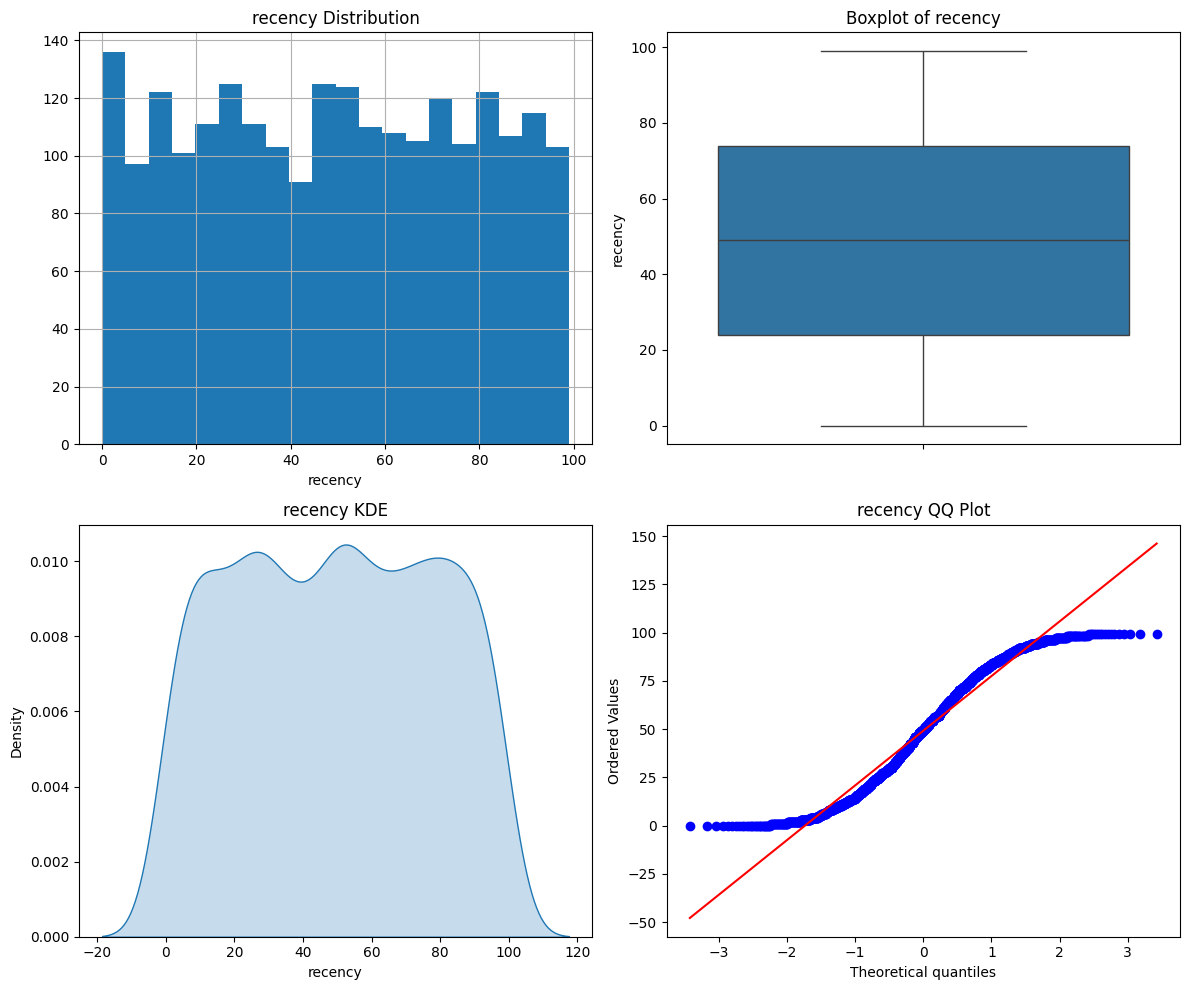

Numerical Column: mnt_wines
##########################################
count    2240.000000
mean      303.935714
std       336.597393
min         0.000000
5%          3.000000
10%         6.000000
20%        16.000000
30%        34.000000
40%        81.000000
50%       173.500000
60%       284.400000
70%       418.600000
80%       581.200000
90%       822.100000
95%      1000.000000
99%      1285.000000
max      1493.000000
Name: mnt_wines, dtype: float64
##########################################


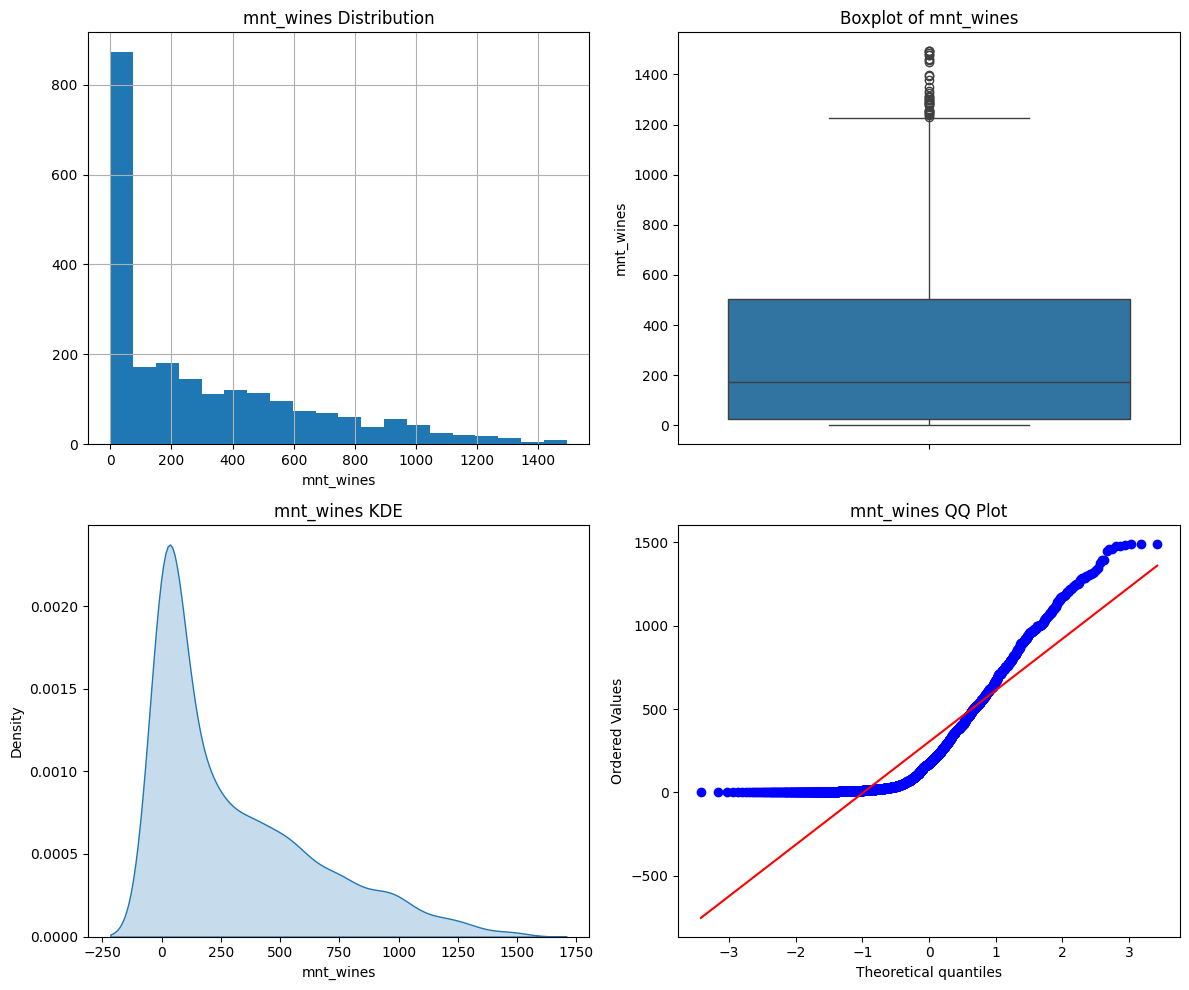

Numerical Column: mnt_fruits
##########################################
count    2240.000000
mean       26.302232
std        39.773434
min         0.000000
5%          0.000000
10%         0.000000
20%         1.000000
30%         2.000000
40%         4.000000
50%         8.000000
60%        15.000000
70%        25.000000
80%        44.000000
90%        83.000000
95%       123.000000
99%       172.000000
max       199.000000
Name: mnt_fruits, dtype: float64
##########################################


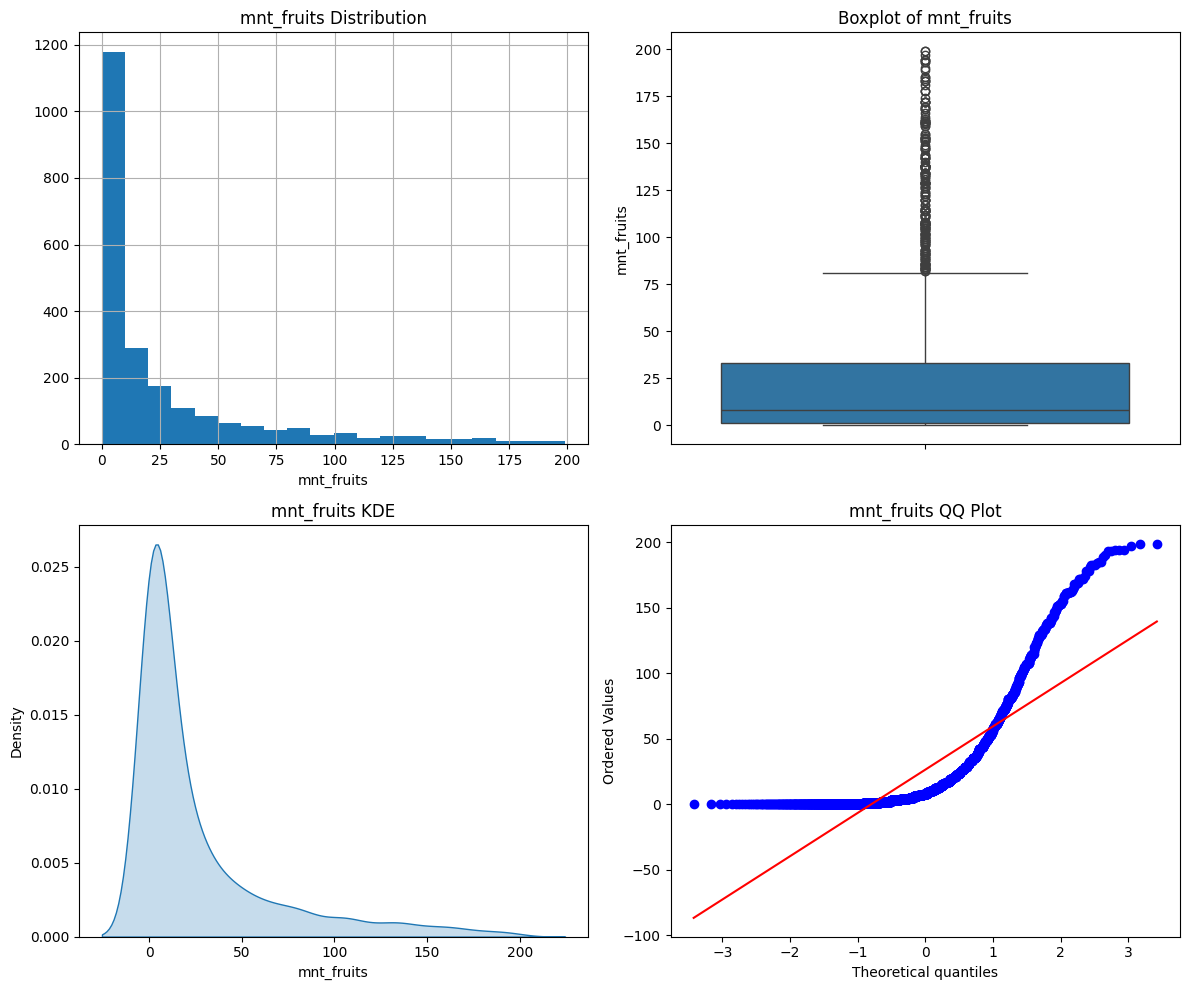

Numerical Column: mnt_meat_products
##########################################
count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
5%          4.000000
10%         7.000000
20%        12.000000
30%        20.000000
40%        35.000000
50%        67.000000
60%       108.400000
70%       177.000000
80%       298.400000
90%       499.000000
95%       687.100000
99%       915.000000
max      1725.000000
Name: mnt_meat_products, dtype: float64
##########################################


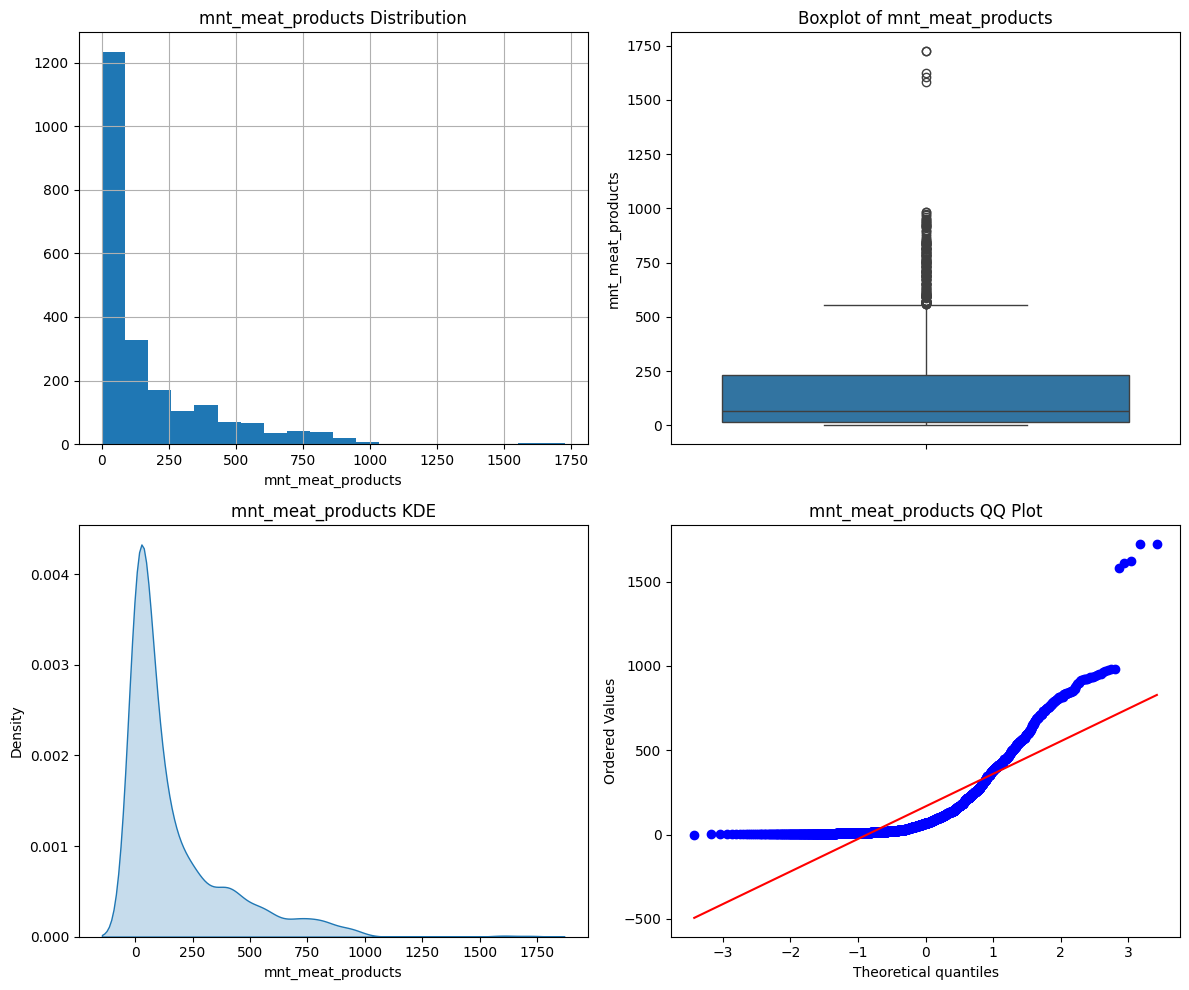

Numerical Column: mnt_fish_products
##########################################
count    2240.000000
mean       37.525446
std        54.628979
min         0.000000
5%          0.000000
10%         0.000000
20%         2.000000
30%         3.000000
40%         7.000000
50%        12.000000
60%        20.000000
70%        37.000000
80%        65.000000
90%       120.000000
95%       168.050000
99%       226.220000
max       259.000000
Name: mnt_fish_products, dtype: float64
##########################################


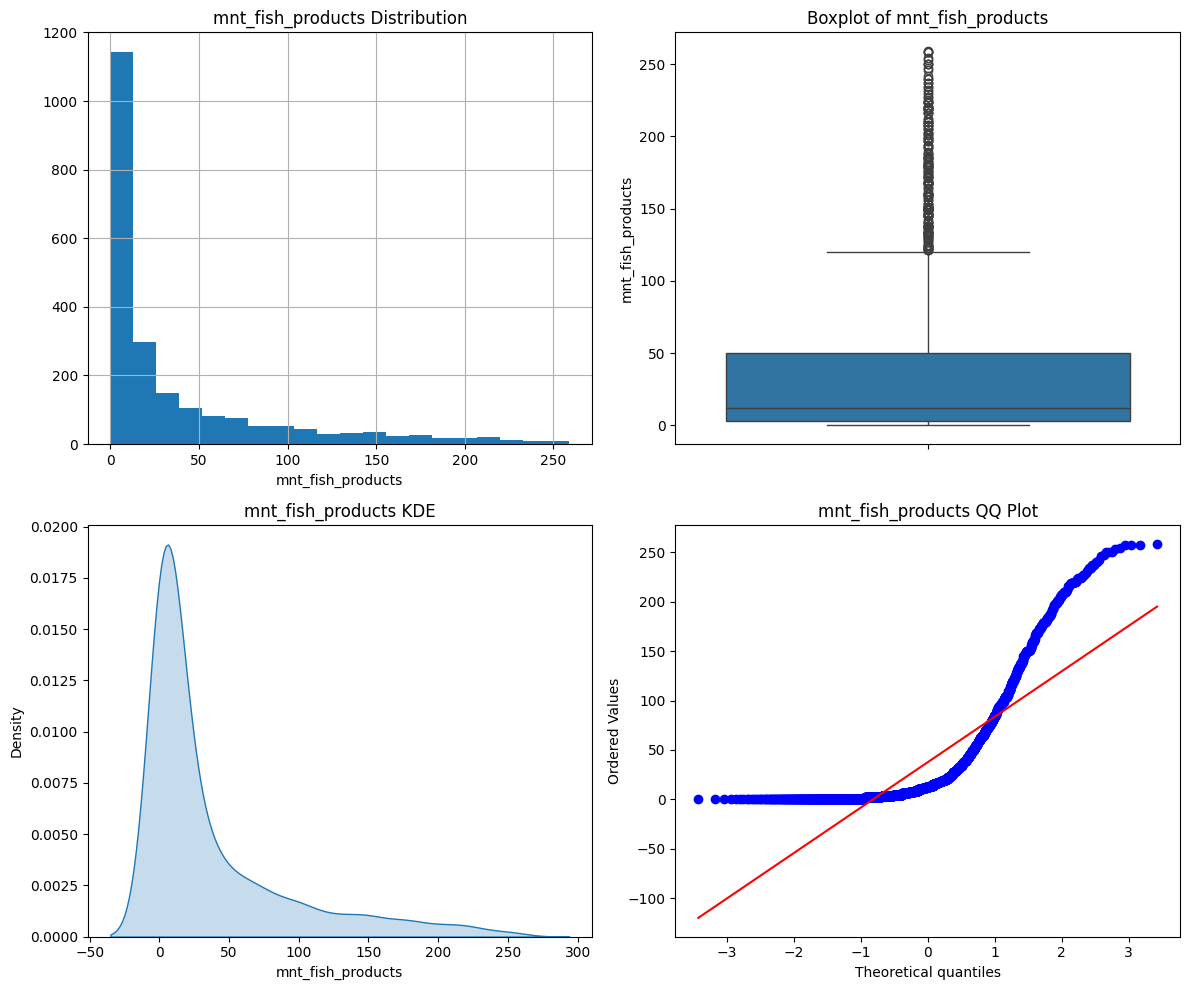

Numerical Column: mnt_sweet_products
##########################################
count    2240.000000
mean       27.062946
std        41.280498
min         0.000000
5%          0.000000
10%         0.000000
20%         1.000000
30%         2.000000
40%         5.000000
50%         8.000000
60%        14.000000
70%        26.000000
80%        44.200000
90%        89.000000
95%       126.000000
99%       177.220000
max       263.000000
Name: mnt_sweet_products, dtype: float64
##########################################


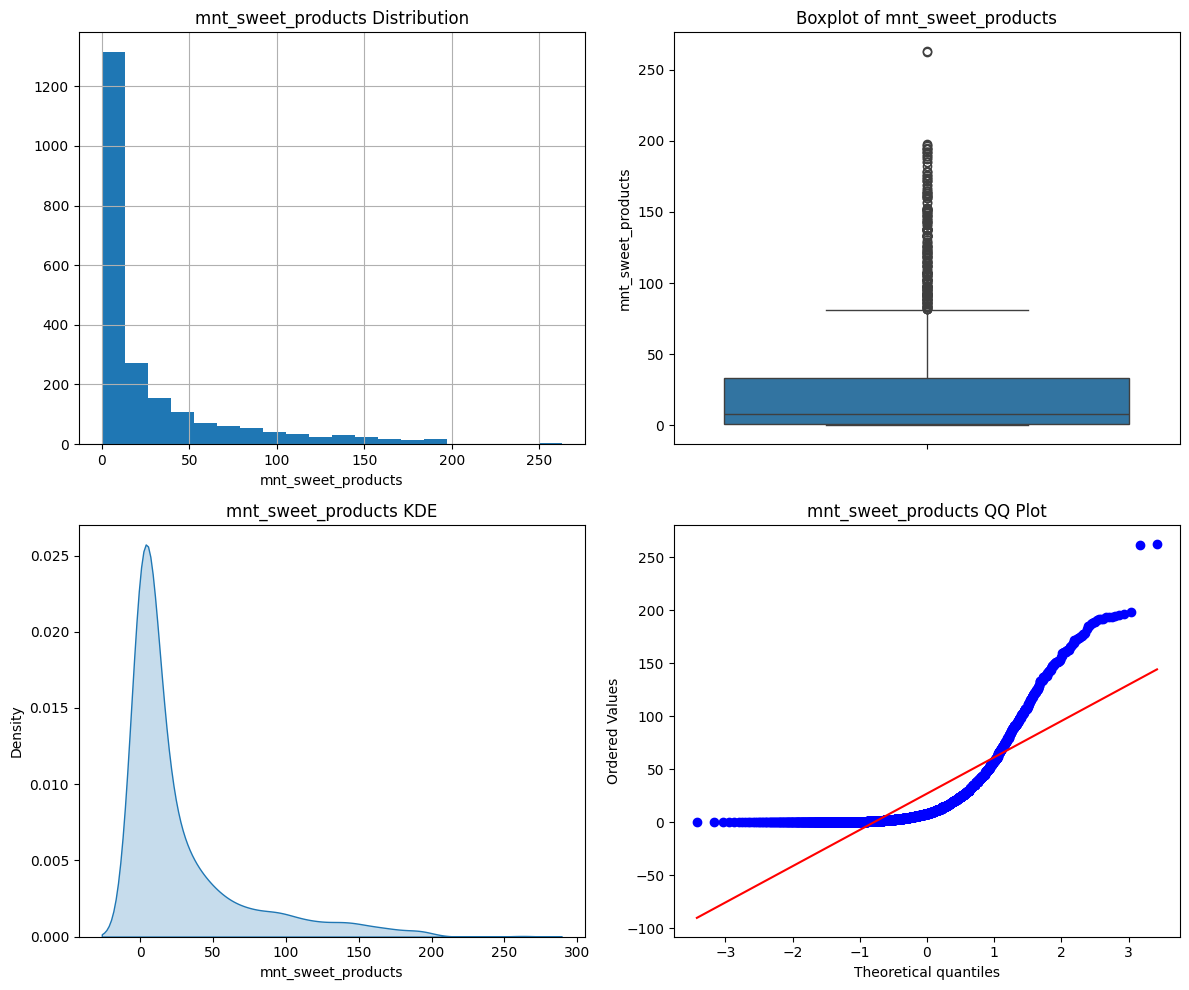

Numerical Column: mnt_gold_prods
##########################################
count    2240.000000
mean       44.021875
std        52.167439
min         0.000000
5%          1.000000
10%         3.000000
20%         6.000000
30%        11.000000
40%        17.000000
50%        24.000000
60%        34.000000
70%        46.000000
80%        73.000000
90%       122.000000
95%       165.050000
99%       227.000000
max       362.000000
Name: mnt_gold_prods, dtype: float64
##########################################


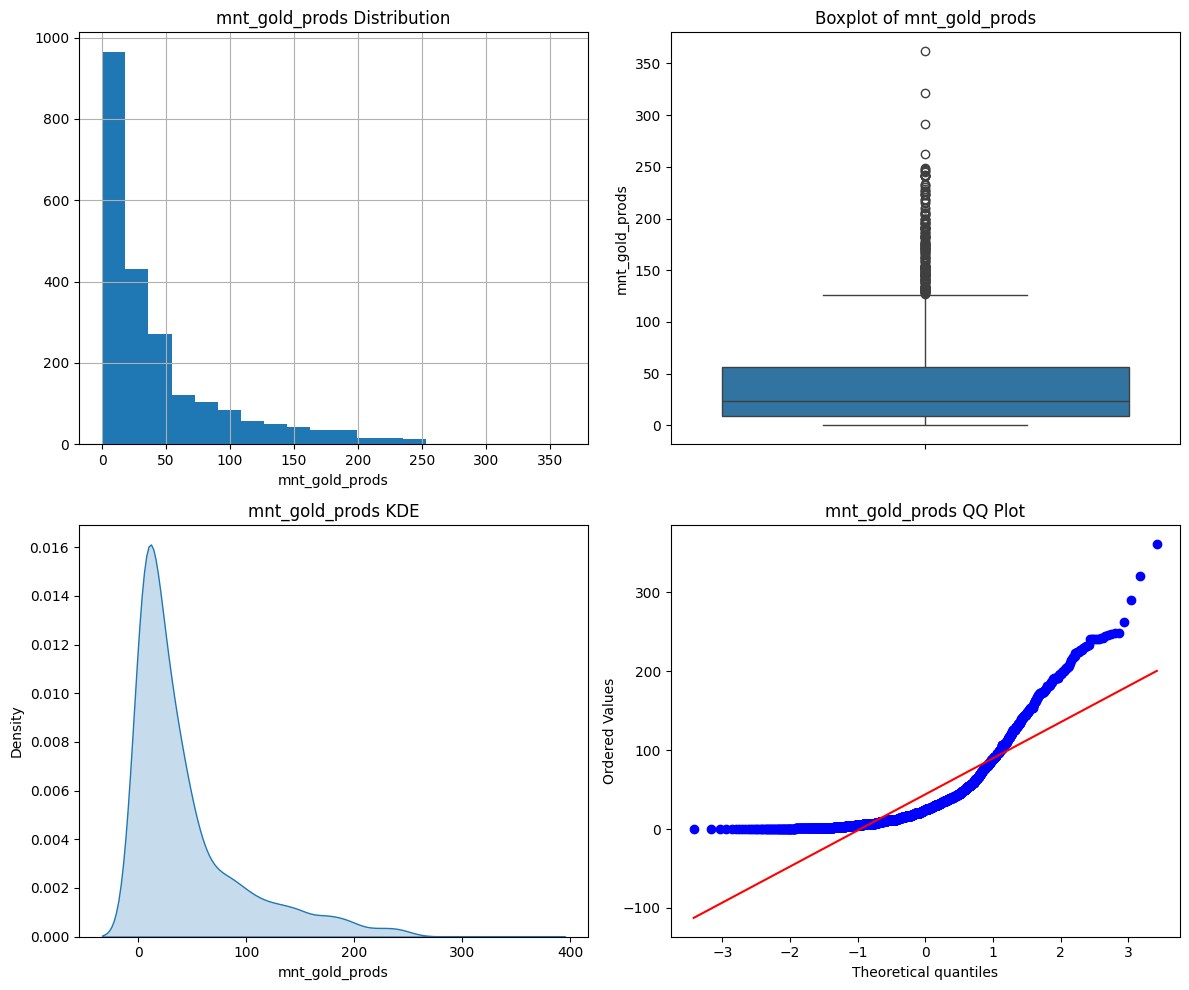

Numerical Column: num_deals_purchases
##########################################
count    2240.000000
mean        2.325000
std         1.932238
min         0.000000
5%          1.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         1.000000
50%         2.000000
60%         2.000000
70%         3.000000
80%         3.000000
90%         5.000000
95%         6.000000
99%        10.000000
max        15.000000
Name: num_deals_purchases, dtype: float64
##########################################


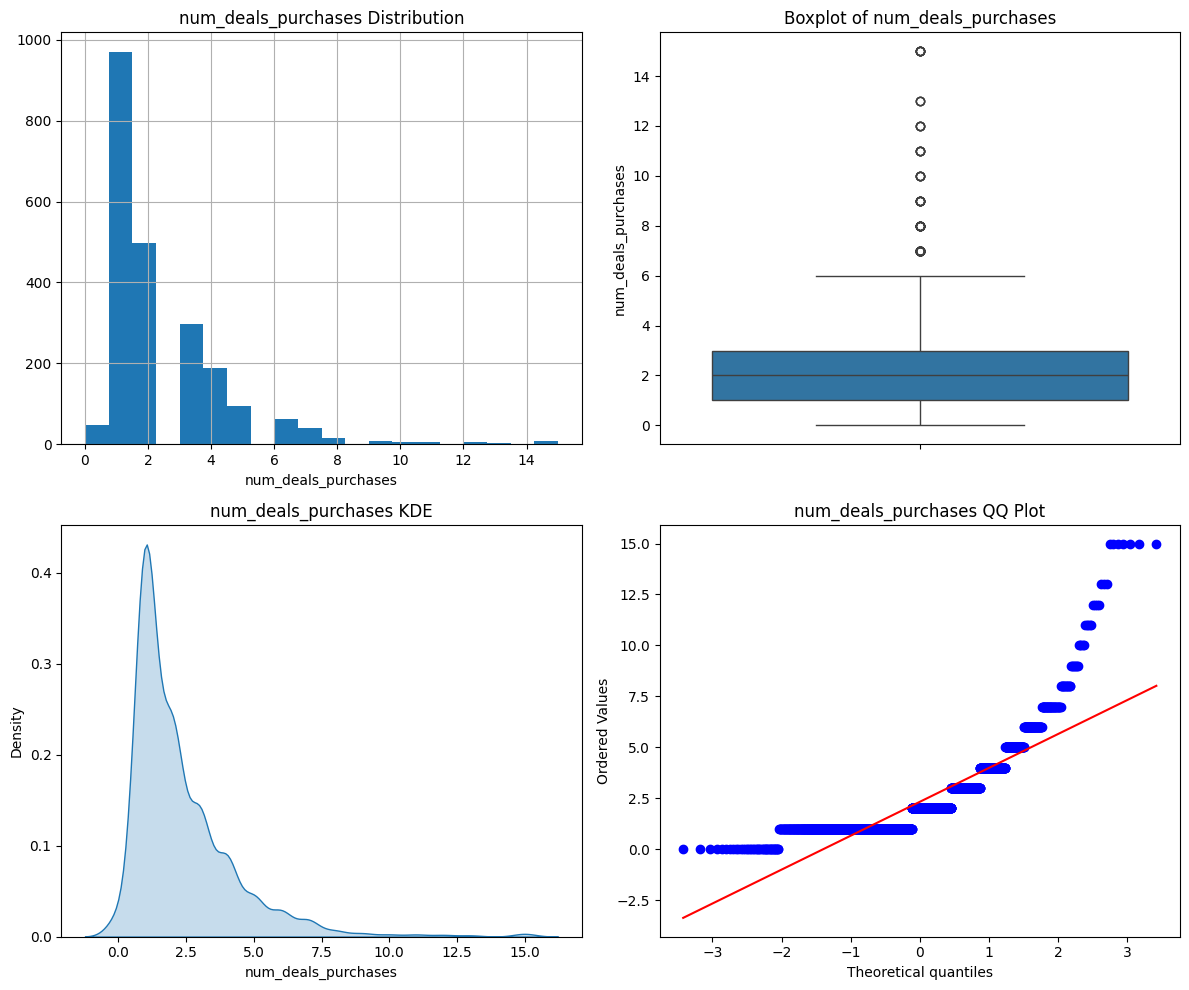

Numerical Column: num_web_purchases
##########################################
count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
5%          1.000000
10%         1.000000
20%         2.000000
30%         2.000000
40%         3.000000
50%         4.000000
60%         4.000000
70%         5.000000
80%         6.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        27.000000
Name: num_web_purchases, dtype: float64
##########################################


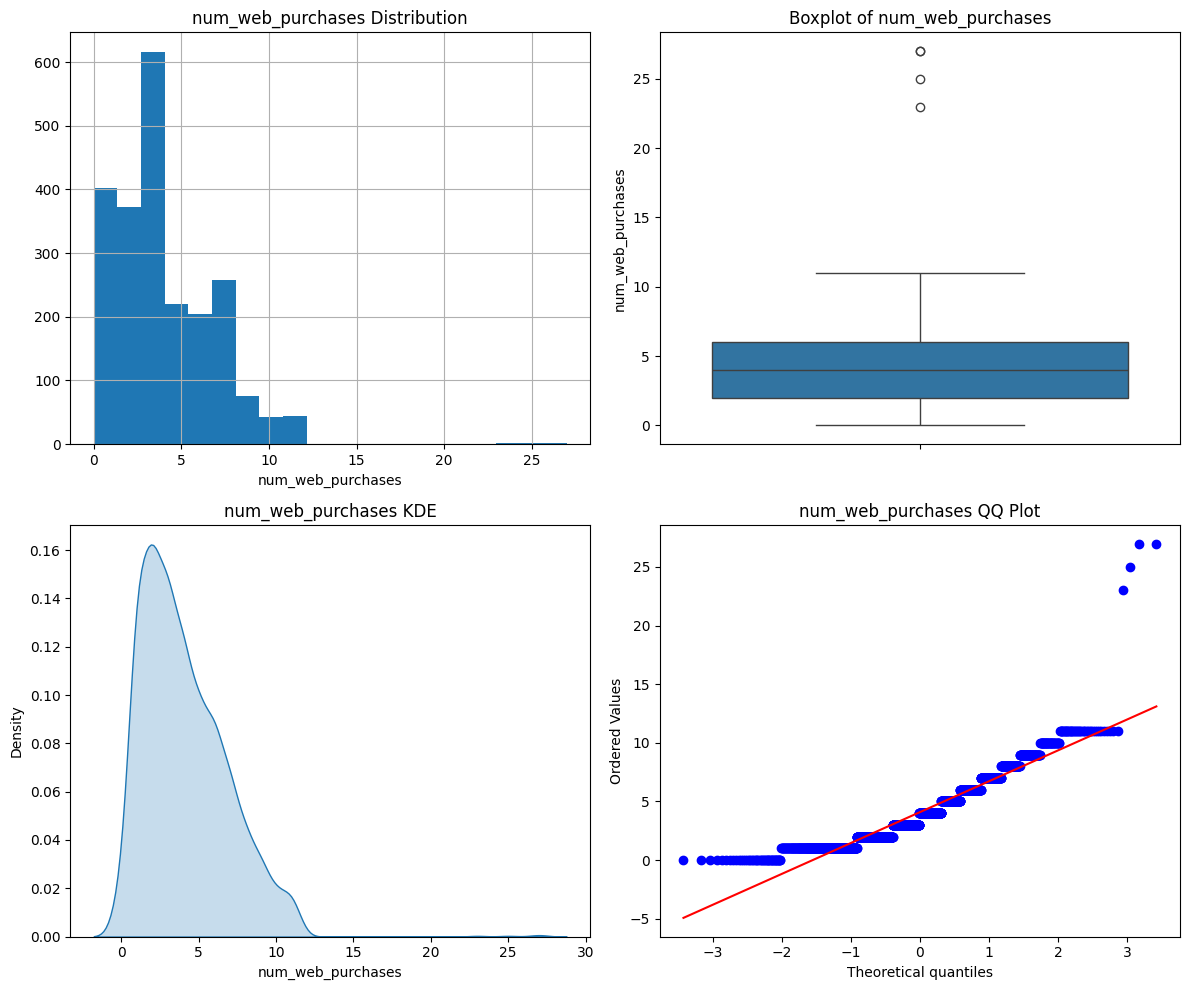

Numerical Column: num_catalog_purchases
##########################################
count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         1.000000
40%         1.000000
50%         2.000000
60%         2.000000
70%         4.000000
80%         5.000000
90%         7.000000
95%         9.000000
99%        10.610000
max        28.000000
Name: num_catalog_purchases, dtype: float64
##########################################


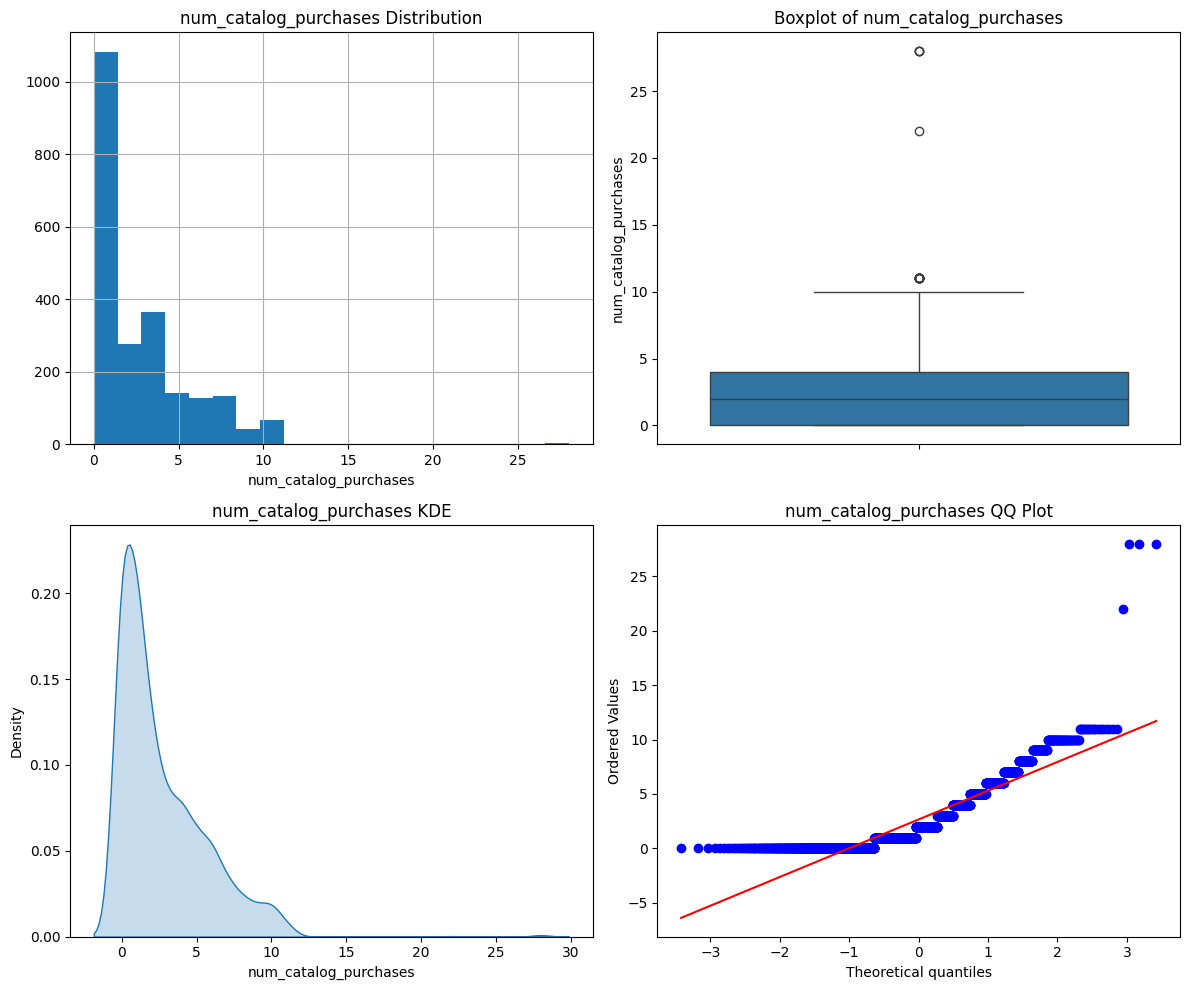

Numerical Column: num_store_purchases
##########################################
count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
5%          2.000000
10%         2.000000
20%         3.000000
30%         3.000000
40%         4.000000
50%         5.000000
60%         6.000000
70%         7.000000
80%         9.000000
90%        11.000000
95%        12.000000
99%        13.000000
max        13.000000
Name: num_store_purchases, dtype: float64
##########################################


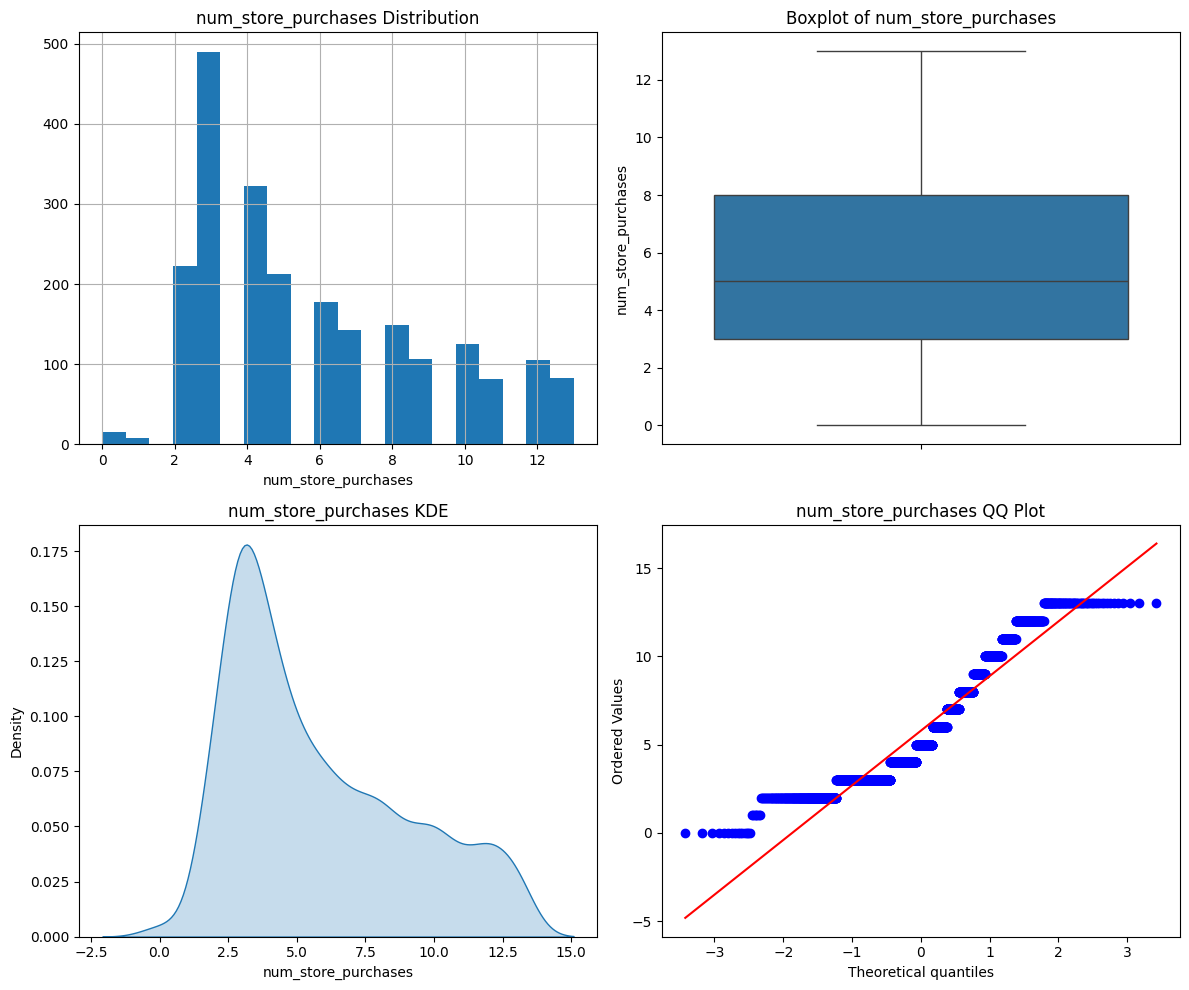

Numerical Column: num_web_visits_month
##########################################
count    2240.000000
mean        5.316518
std         2.426645
min         0.000000
5%          1.000000
10%         2.000000
20%         3.000000
30%         4.000000
40%         5.000000
50%         6.000000
60%         6.000000
70%         7.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%         9.000000
max        20.000000
Name: num_web_visits_month, dtype: float64
##########################################


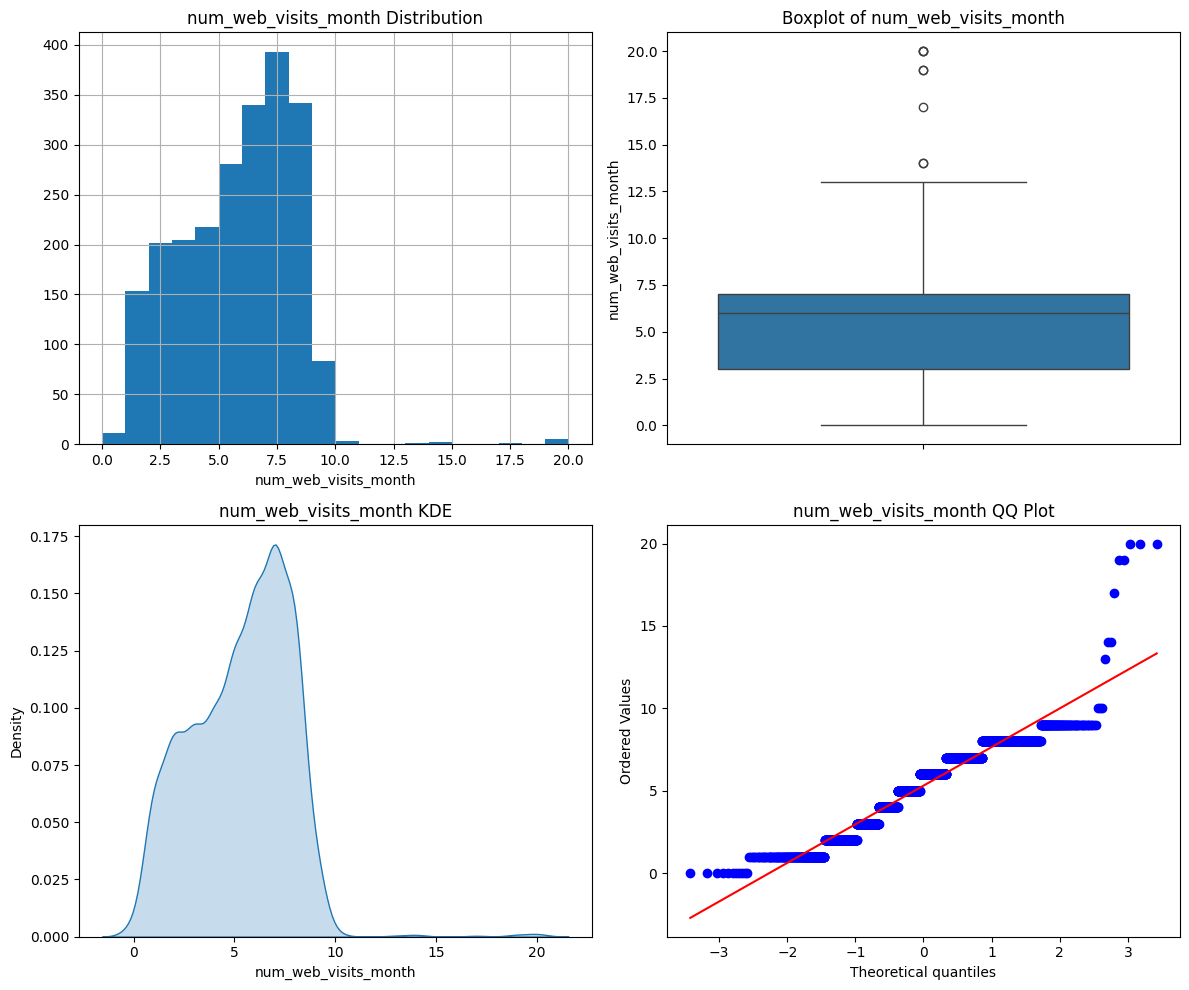

Numerical Column: age
##########################################
count    2240.000000
mean       55.194196
std        11.984069
min        28.000000
5%         36.000000
10%        40.000000
20%        45.000000
30%        48.000000
40%        51.000000
50%        54.000000
60%        58.000000
70%        62.000000
80%        67.000000
90%        72.000000
95%        74.000000
99%        79.000000
max       131.000000
Name: age, dtype: float64
##########################################


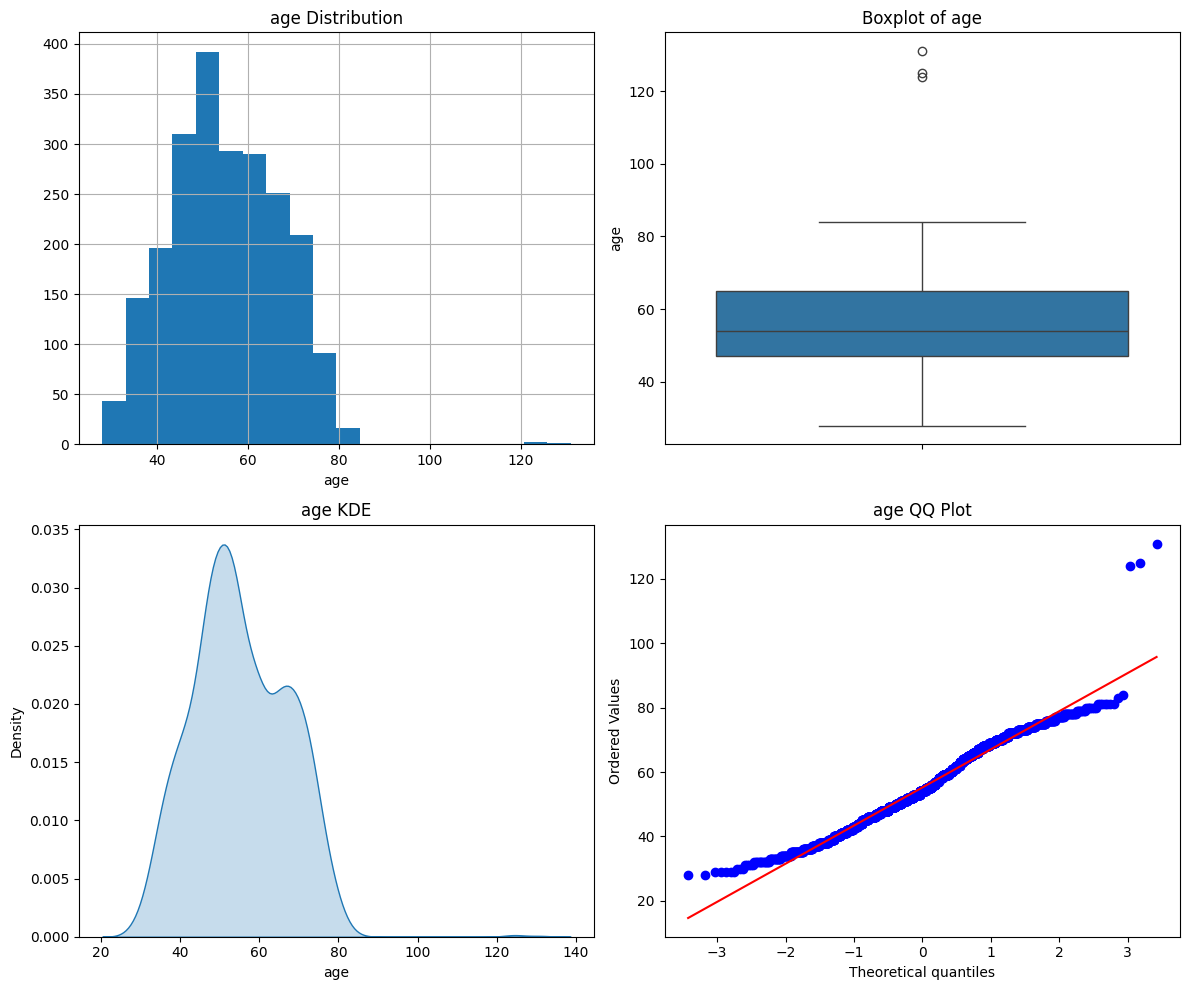

Numerical Column: total_spending
##########################################
count    2240.000000
mean      605.798214
std       602.249288
min         5.000000
5%         22.000000
10%        34.900000
20%        55.000000
30%        91.000000
40%       194.600000
50%       396.000000
60%       635.400000
70%       926.000000
80%      1174.000000
90%      1536.200000
95%      1772.300000
99%      2126.000000
max      2525.000000
Name: total_spending, dtype: float64
##########################################


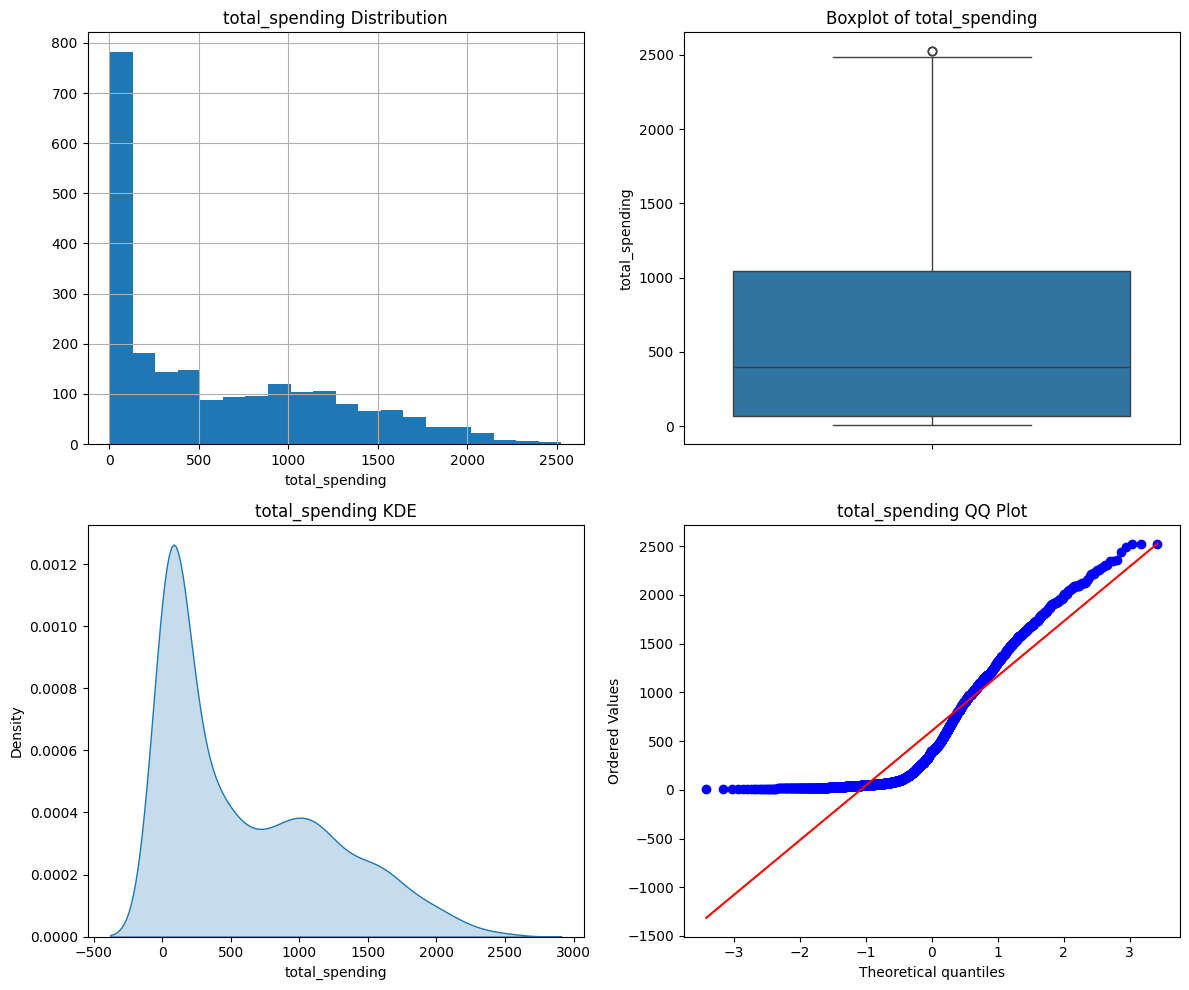

Numerical Column: days_as_customer
##########################################
count    2240.000000
mean     4150.582143
std       202.122512
min      3797.000000
5%       3835.000000
10%      3868.900000
20%      3939.000000
30%      4016.000000
40%      4081.600000
50%      4152.500000
60%      4220.000000
70%      4292.000000
80%      4361.000000
90%      4432.100000
95%      4464.000000
99%      4488.000000
max      4496.000000
Name: days_as_customer, dtype: float64
##########################################


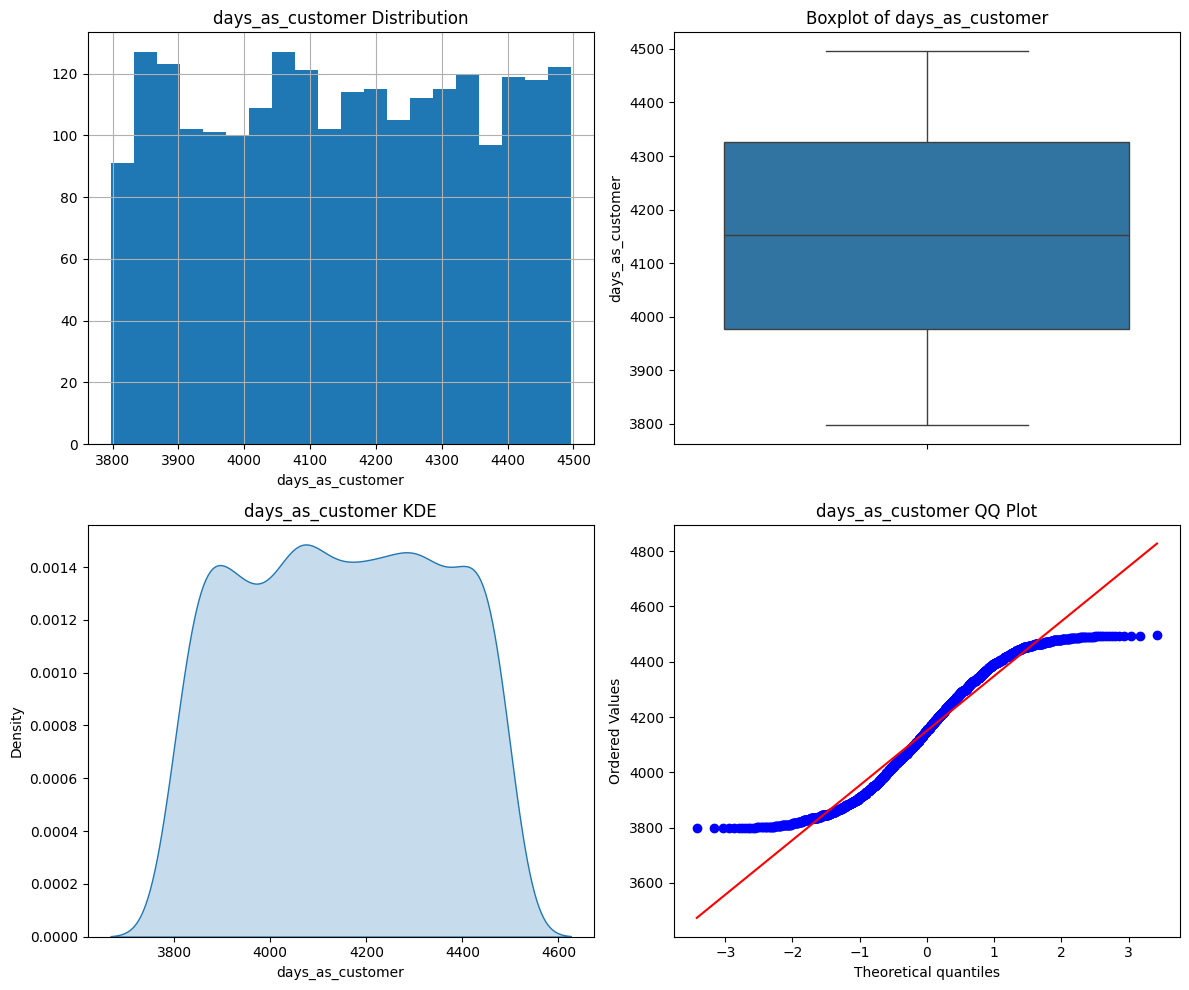

In [31]:
for col in numerical_cols:
    num_summary(dataframe=data_eda,numerical_col=col, plot=True)

In [23]:
# Cap the outliers with the thresholds
for col in numerical_cols:
    replace_with_thresholds(data_eda, col)

In [24]:
# Check for outliers again after the capping is applied
for col in numerical_cols:
    print(col, check_outlier(data_eda, col))

income False
recency False
mnt_wines False
mnt_fruits False
mnt_meat_products False
mnt_fish_products False
mnt_sweet_products False
mnt_gold_prods False
num_deals_purchases False
num_web_purchases False
num_catalog_purchases False
num_store_purchases False
num_web_visits_month False
age False
total_spending False
days_as_customer False


In [26]:
# Check for Skewness after outliers capping
data_eda[numerical_cols].skew(axis=0, skipna=True)

income                   0.429731
recency                 -0.001987
mnt_wines                1.175771
mnt_fruits               2.102063
mnt_meat_products        2.078199
mnt_fish_products        1.919769
mnt_sweet_products       2.136081
mnt_gold_prods           1.886106
num_deals_purchases      2.247969
num_web_purchases        1.023028
num_catalog_purchases    1.522103
num_store_purchases      0.702237
num_web_visits_month     0.113887
age                      0.349944
total_spending           0.860841
days_as_customer        -0.015216
dtype: float64

In [35]:
numerical_cols = [col for col in numerical_cols if col not in outlier_cols]
print(f"numerical_cols: {numerical_cols}")
print(f"categorical_cols: {categorical_cols}")
print(f"outlier_cols: {outlier_cols}")

numerical_cols: ['recency', 'mnt_wines', 'mnt_fruits', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'num_store_purchases', 'age', 'total_spending', 'days_as_customer']
categorical_cols: ['education', 'complain', 'response', 'family_size', 'offers_responded_to', 'parental_status']
outlier_cols: ['income', 'mnt_meat_products', 'num_deals_purchases', 'num_web_purchases', 'num_catalog_purchases', 'num_web_visits_month']


In [43]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [65]:
numerical_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='median', fill_value=0)),
                             ("StandardScaler", StandardScaler())]
                           )

outlier_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='median', fill_value=0)),
                            ("transformer", PowerTransformer(standardize=True))]
                                    )

categorical_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='most_frequent', fill_value='missing')),
                             ("ordinal", OrdinalEncoder())]
                           )

preprocessor = ColumnTransformer(
    [
        ("num",numerical_pipeline, numerical_cols),
        ("Out", outlier_pipeline, outlier_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ]
)

processor = Pipeline(steps=
                     [("preprocessor", preprocessor),
                     ("std_scaler", StandardScaler())]
)

In [59]:
data_eda[categorical_cols].head()

education  complain  response  family_size  offers_responded_to  \
0          2         0         1            1                    1   
1          2         0         0            3                    0   
2          2         0         0            2                    0   
3          2         0         0            3                    0   
4          4         0         0            3                    0   

   parental_status  
0                0  
1                1  
2                0  
3                1  
4                1

In [76]:
df = data_eda.copy()
columns = df.columns
df = processor.fit_transform(df)
scaled_data = pd.DataFrame(df, columns=columns)
print("After scaling, let's have a glimpse of the scaled dataset :")
scaled_data.head()

After scaling, let's have a glimpse of the scaled dataset :


education    income   recency  mnt_wines  mnt_fruits  mnt_meat_products  \
0   0.307039  0.983781  1.551577   2.462147    1.476500           0.843207   
1  -0.383664 -0.870479 -0.636301  -0.650449   -0.631503          -0.729006   
2  -0.798086  0.362723  0.570804   1.345274   -0.146905          -0.038766   
3  -0.798086 -0.870479 -0.560857  -0.503974   -0.583043          -0.748179   
4   1.550305 -0.389085  0.419916   0.155164   -0.001525          -0.556446   

   mnt_fish_products  mnt_sweet_products  mnt_gold_prods  num_deals_purchases  \
0          -0.550785            0.985345        1.679417             1.531185   
1          -1.166125            1.235733       -0.961275            -1.190545   
2           1.295237            0.317643        0.282673            -0.205773   
3          -0.550785           -1.268149       -0.918094            -1.061881   
4           0.064556           -1.017761       -0.305254            -0.953012   

   num_web_purchases  num_catalog_purchases  num_store_purchases  \
0           0.366456               1.419915             0.745002   
1          -0.140050              -1.377137             0.158995   
2           0.881629               0.446761            -0.819643   
3          -1.173940              -0.706341             0.158995   
4           0.372726               0.399025             1.443178   

   num_web_visits_month  complain  response       age  family_size  \
0              1.329470  1.726361  0.703657 -0.458383    -0.097282   
1             -1.359729 -0.373607 -0.101636 -0.458383    -0.097282   
2              1.329470  0.159579 -0.517528 -0.458383    -0.097282   
3             -0.708520 -1.337974  0.304922 -0.458383    -0.097282   
4              0.527485  0.524677 -0.101636  1.533425    -0.097282   

   total_spending  days_as_customer  offers_responded_to  parental_status  
0        2.388846         -1.759115             0.621248        -1.584605  
1       -0.418612          0.446548            -0.501912         0.631072  
2       -0.418612         -0.656283            -0.501912        -1.584605  
3       -0.418612          0.446548            -0.501912         0.631072  
4       -0.418612          0.446548            -0.501912         0.631072

### Model Development: Clustering

Since the dataset is unsupervised, it does not include a predefined target variable. To address this, we will employ clustering algorithms to group the data into clusters, effectively creating target labels based on inherent patterns.

#### What is Clustering?

Clustering is a machine learning technique used to identify natural groupings within a dataset. By applying a clustering algorithm, the model analyses unlabelled data and uncovers groupings, referred to as *clusters*. Each cluster represents a collection of data points that are similar to one another based on their characteristics and proximity within the data space.

For this clustering task, the following four algorithms will be explored:

- **K-Means Clustering**
- **Agglomerative Clustering**
- **Gaussian Mixture Model (GMM)**
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

### What is the Silhouette Score?

The **silhouette score** is a metric used to evaluate the quality of clustering. It quantifies how well a data point fits within its own cluster (*cohesion*) compared to its alignment with the closest neighbouring cluster (*separation*). The score ranges from **-1 to +1**:

- **+1**: The data point is well-clustered, meaning it is strongly associated with its own cluster and far from neighbouring clusters.  
- **0**: The data point is on the boundary between clusters, indicating overlapping clusters or uncertainty in grouping.  
- **-1**: The data point may be misclassified, as it is closer to a neighbouring cluster than its own.  

A higher silhouette score suggests more distinct and well-defined clusters. It is commonly used to compare and select the optimal clustering algorithm or configuration.

In [67]:
# this function we take it from sklearn page for ploting silhouette with little Modification
#ploting silhouette_plot aside with clustring results in PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm
from sklearn.decomposition import PCA

In [68]:
def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

### PCA (Principal Component Analysis)

Given the presence of high correlations among features, dimensionality reduction is a suitable approach to simplify the dataset. One effective technique for this is **Principal Component Analysis (PCA)**.

#### What is PCA?

**Principal Component Analysis** is a widely-used dimensionality reduction technique that transforms a large set of correlated variables into a smaller set of uncorrelated variables called **principal components**, while retaining most of the information present in the original dataset.  

#### Why Use PCA?

- **Simplification**: Reduces the number of variables, making the dataset easier to analyse and interpret.
- **Efficiency**: Smaller datasets are computationally less demanding, allowing machine learning algorithms to train faster and more effectively.
- **Visualisation**: Reducing dimensions enables better data visualisation, especially when working with high-dimensional data.

#### Trade-offs in Dimensionality Reduction

While PCA reduces dimensionality, it comes at the cost of some loss of accuracy. The goal is to strike a balance by preserving as much information as possible while simplifying the dataset. This makes it easier to explore, process, and interpret without redundant or irrelevant features interfering with analysis.

In [ ]:
#Applying PCA

df_scaled = scaled_data.copy()
var_ratio={}
for n in range(2,18):
    pc=PCA(n_components=n)
    df_pca=pc.fit(df_scaled)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

### Choosing PCA` n_components` and Kmeans `n_clusters` based on Clustering metrics

In [90]:
# apply PCA and display clustering metrics
from sklearn.cluster import KMeans
for y in range(2, 8):
    print("PCA with # of components: ", y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(df_scaled)
    for x in range(2, 7):
        kmeans = KMeans(n_clusters = x,)
        label = kmeans.fit_predict(data_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(scaled_data, label) , '-  Inertia: ',kmeans.inertia_)
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.2735607076883106 -  Inertia:  8861.900605627046
Silhouette-Score for 3 Clusters:  0.19488663766661457 -  Inertia:  4995.014289777844
Silhouette-Score for 4 Clusters:  0.12237328436023524 -  Inertia:  3906.5589031332793
Silhouette-Score for 5 Clusters:  0.11419159759780673 -  Inertia:  3349.2988979935562
Silhouette-Score for 6 Clusters:  0.06826803306468152 -  Inertia:  2823.5279409263994

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.2736119180857976 -  Inertia:  12838.833287432062
Silhouette-Score for 3 Clusters:  0.19470871271057044 -  Inertia:  8937.294138082078
Silhouette-Score for 4 Clusters:  0.19088655337254012 -  Inertia:  7142.073823227498
Silhouette-Score for 5 Clusters:  0.13820171302990994 -  Inertia:  6129.367541153534
Silhouette-Score for 6 Clusters:  0.133679312619302 -  Inertia:  5170.764272525928

PCA with # of components:  4
Silhouette-Score for 2 Clusters:  0.2730113223999324 -  Inert

In [91]:
# Reducing the dimensions of the data
pca_final=PCA(n_components=2,random_state=42).fit(scaled_data)

reduced=pca_final.fit_transform(scaled_data)
pcadf = pd.DataFrame(reduced)
pcadf.columns = ['PC1', 'PC2']

pcadf.head(10)

PC1       PC2
0  4.553434  0.476509
1 -2.746754 -0.707086
2  2.222121 -0.822660
3 -2.948589 -0.735307
4 -0.119805  1.078587
5  0.747765  1.283948
6  0.813009  1.252738
7 -2.306166  0.622070
8 -2.527008  0.032965
9 -5.071475  0.741679

### Explained Variance Ratio in PCA

The **explained variance ratio** represents the proportion of the dataset's total variance that is captured by each principal component. It provides insight into how much information (or variability) is retained by each component. 

- A higher **explained variance ratio** for a component indicates that it captures a significant portion of the dataset's variability.
- The cumulative explained variance helps determine the number of components needed to retain a desired level of information (e.g., 95% of the variance).

This metric is crucial in selecting the optimal number of principal components, balancing dimensionality reduction with information preservation.

In [92]:
pca_final.explained_variance_ratio_

array([0.35713197, 0.10095674])

### Elbow Method for Determining Optimal Clusters in K-Means

The **Elbow Method** is a commonly used technique to identify the optimal number of clusters (\(K\)) for K-Means clustering. It involves the following steps:

1. **Varying the Number of Clusters**: 
   - Vary \(K\) from 1 to a pre-determined range (e.g., 1 to 10).
   
2. **Calculating WCSS**:
   - Compute the **Within-Cluster Sum of Squares (WCSS)** for each \(K\).  
   - **WCSS** measures the sum of squared distances between each data point and the centroid of its cluster.  
   - A lower WCSS indicates better clustering since data points are closer to their respective cluster centroids.  

3. **Plotting WCSS vs. \(K\)**:
   - The WCSS values are plotted against the number of clusters (\(K\)).  
   - As \(K\) increases, WCSS decreases because clusters become smaller and tighter.

4. **Identifying the 'Elbow Point'**:
   - The **elbow point** is where the WCSS reduction slows significantly, creating an "elbow" in the plot.  
   - This point indicates the optimal number of clusters, as further increasing \(K\) provides minimal improvement in WCSS while adding complexity.

This method balances clustering accuracy and model simplicity by avoiding overfitting with too many clusters.

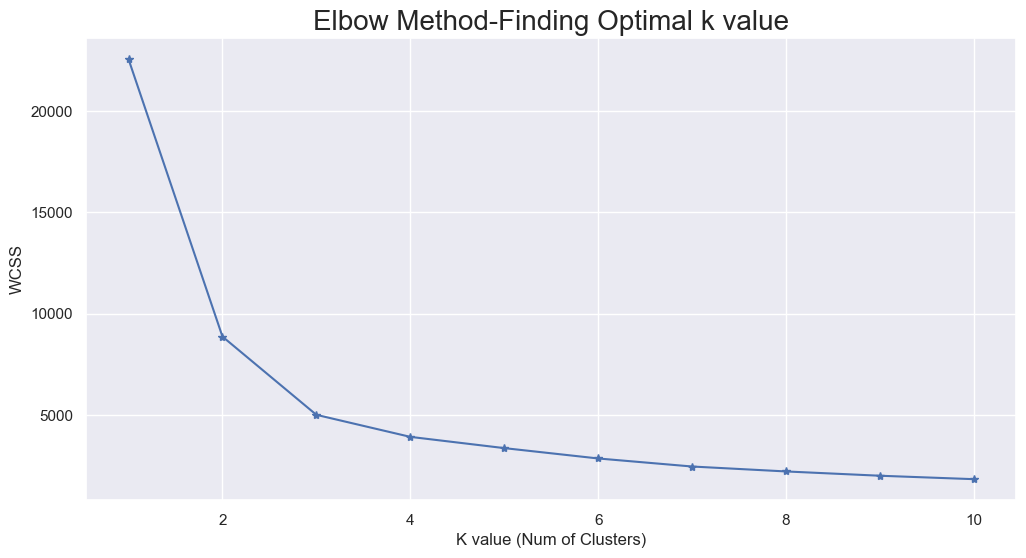

In [93]:
wcss= {}
sns.set()
plt.figure(figsize=(12,6))
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(pcadf)
    wcss[i]=km.inertia_

plt.plot(range(1,11),wcss.values(), marker='*')
plt.title('Elbow Method-Finding Optimal k value', fontsize =20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

The elbow method plot shows the relationship between the number of clusters (K) and the Within-Cluster Sum of Squares (WCSS). The WCSS measures the compactness of the clusters.

**Interpretation:**

* As the number of clusters increases, the WCSS decreases. This is because with more clusters, the data points are closer to their respective cluster centers.
* The "elbow point" is the point where the rate of decrease in WCSS starts to level off. This is considered the optimal number of clusters.

**In this case, the elbow point appears to be around K = 3.**

**Commentary:**

* The sharp decrease in WCSS from K = 1 to K = 3 indicates a significant improvement in cluster formation.
* After K = 3, the decrease in WCSS becomes more gradual, suggesting diminishing returns from adding more clusters.
* Choosing K = 3 strikes a balance between maximizing cluster separation and minimizing the number of clusters.
* Domain knowledge and the specific goals of the analysis can also influence the final decision on the number of clusters.

**Conclusion:**

Based on the elbow method, **K = 3** seems to be a reasonable choice for the number of clusters in this dataset.

### Silhoutte Score Plot for K-Means to choose best number of clusters


For n_clusters = 3 The average silhouette_score is : 0.5092036701495153
For n_clusters = 4 The average silhouette_score is : 0.4394408676669737
For n_clusters = 5 The average silhouette_score is : 0.40313464041510494
For n_clusters = 6 The average silhouette_score is : 0.34737124612496323


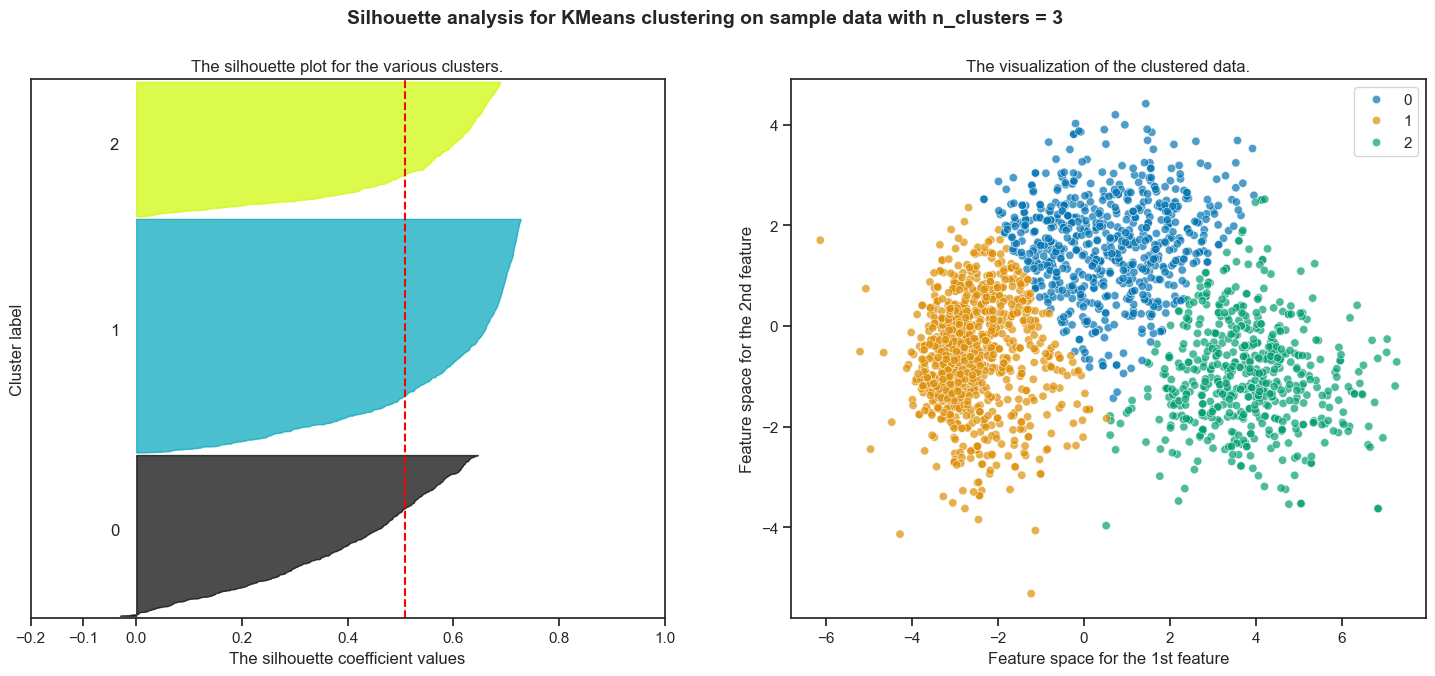

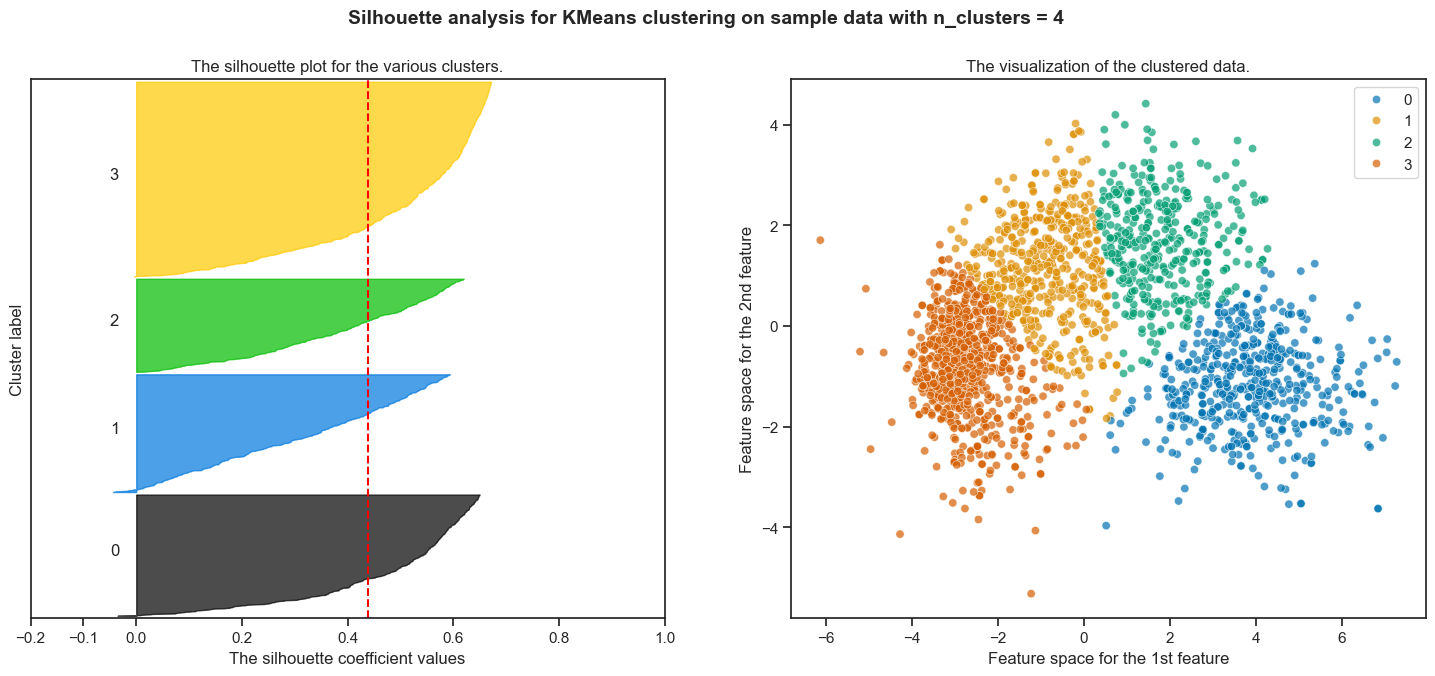

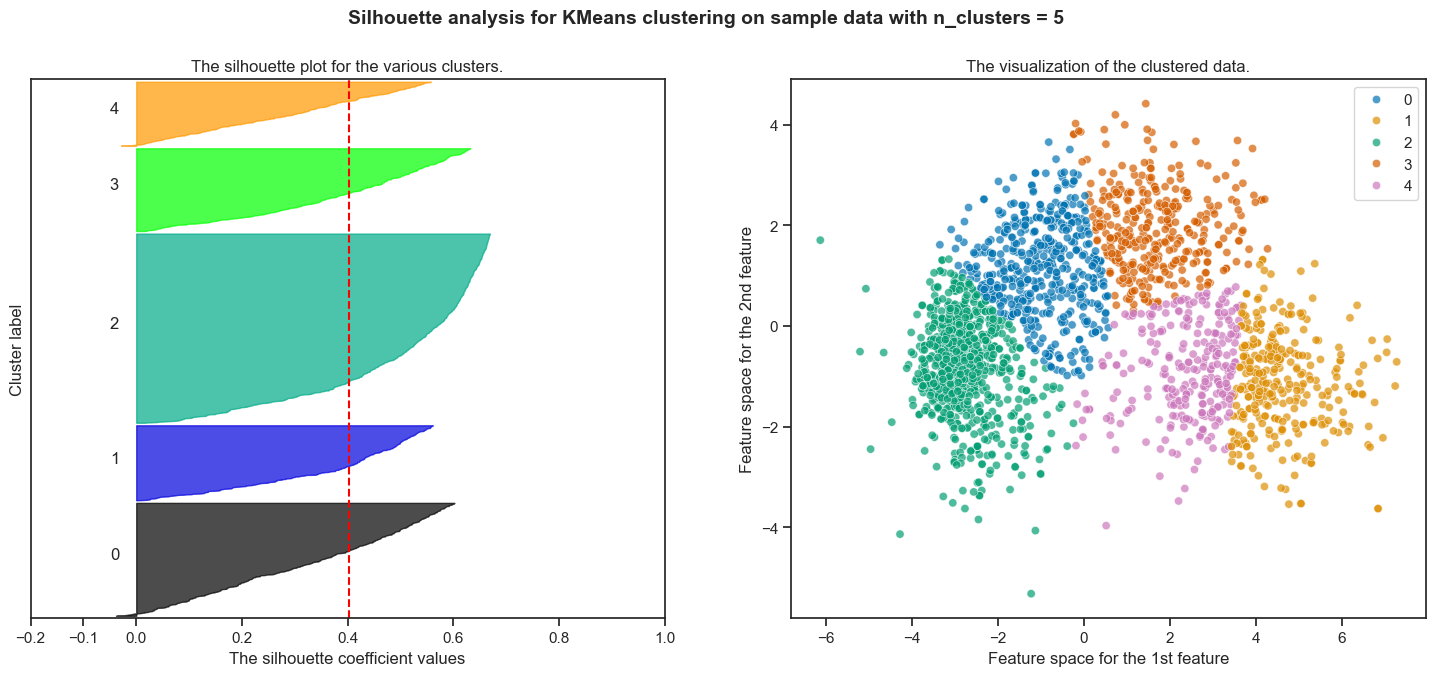

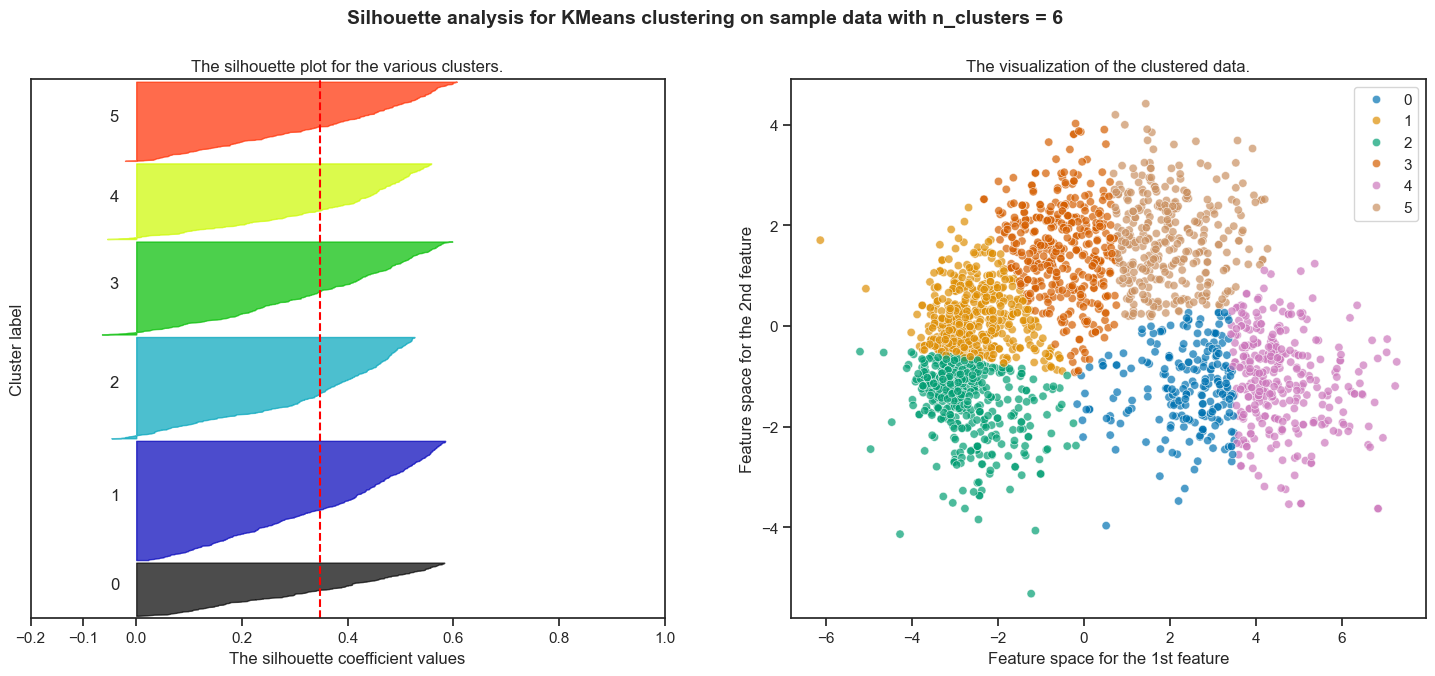

In [94]:
# We plot silhoutte score for Kmeans
# Here pcadf is pca dataframe, and Reduced is array of data after PCA.
sns.set_style('ticks')
silhouette_plot(KMeans,range(3,7), pcadf, reduced)

### Apply Kmeans Clustering with 3 clusters

In [73]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

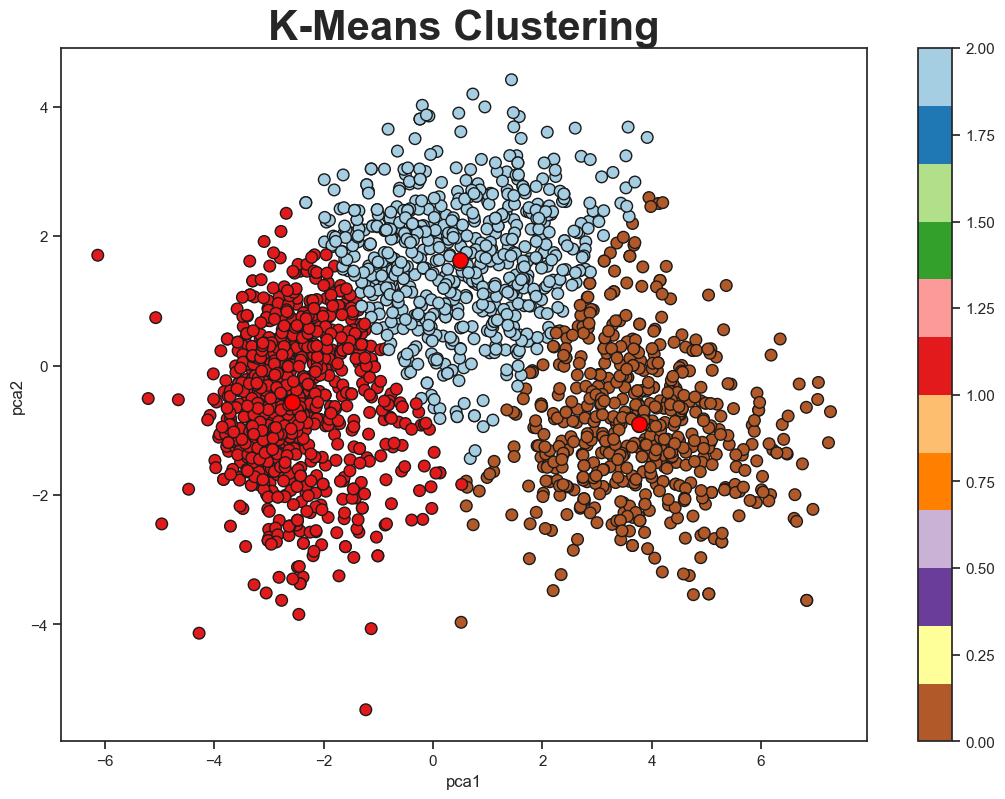

In [74]:
#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k');

### Hierarchical Clustering (Agglomerative)

**Agglomerative Clustering** is a type of hierarchical clustering that follows a **bottom-up approach**, often referred to as **Hierarchical Agglomerative Clustering (HAC)**. Unlike flat clustering methods (e.g., K-Means), hierarchical clustering provides a dendrogram—a tree-like structure that visually represents how clusters are formed.

#### Key Features of Agglomerative Clustering:
1. **No Prespecified Number of Clusters**: 
   - Unlike algorithms such as K-Means, agglomerative clustering does not require defining the number of clusters beforehand. Instead, clusters can be determined based on a threshold distance or by analysing the dendrogram.

2. **Bottom-Up Approach**:
   - Initially, each data point is considered its own cluster (*singleton cluster*).  
   - Pairs of clusters are iteratively merged based on a similarity metric until all data points are combined into a single cluster.

3. **Informative Structure**:
   - The output is more structured and detailed than flat clustering algorithms, making it useful for visualising the relationships between clusters at different levels of granularity.

#### Steps in Agglomerative Clustering:
1. Start with each data point as an individual cluster.
2. Compute the distance (or similarity) between clusters using a chosen metric, such as:
   - **Single Linkage**: Minimum distance between points in two clusters.
   - **Complete Linkage**: Maximum distance between points in two clusters.
   - **Average Linkage**: Average distance between points in two clusters.
   - **Ward’s Method**: Minimises the increase in total variance when merging clusters.
3. Merge the closest clusters.
4. Repeat until a single cluster containing all data points is formed.

This method is particularly useful for datasets where the natural hierarchy or relationships between data points is important to explore.

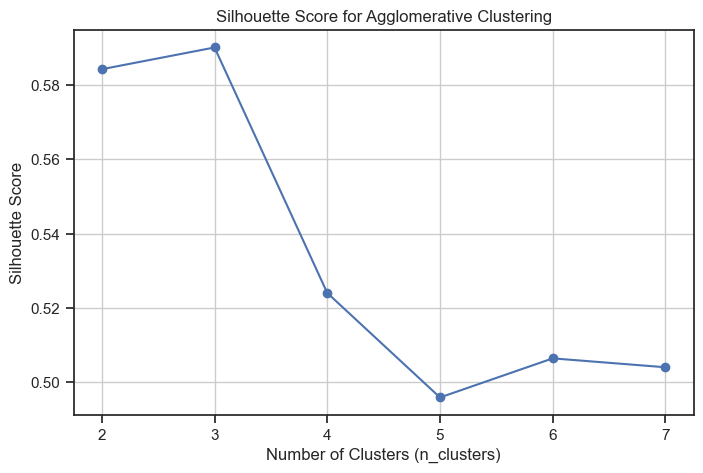

In [96]:
# Generate silhouette scores for a range of cluster numbers
from sklearn.cluster import AgglomerativeClustering

n_clusters_range = range(2, 8)
silhouette_scores = []

for n_clusters in n_clusters_range:
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(data_eda)  # Replace X with your dataset
    score = silhouette_score(data_eda, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid()
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.5033138282177081
For n_clusters = 4 The average silhouette_score is : 0.4362712222835716
For n_clusters = 5 The average silhouette_score is : 0.3994005269142436
For n_clusters = 6 The average silhouette_score is : 0.3486117630948185
For n_clusters = 7 The average silhouette_score is : 0.28662335646384673


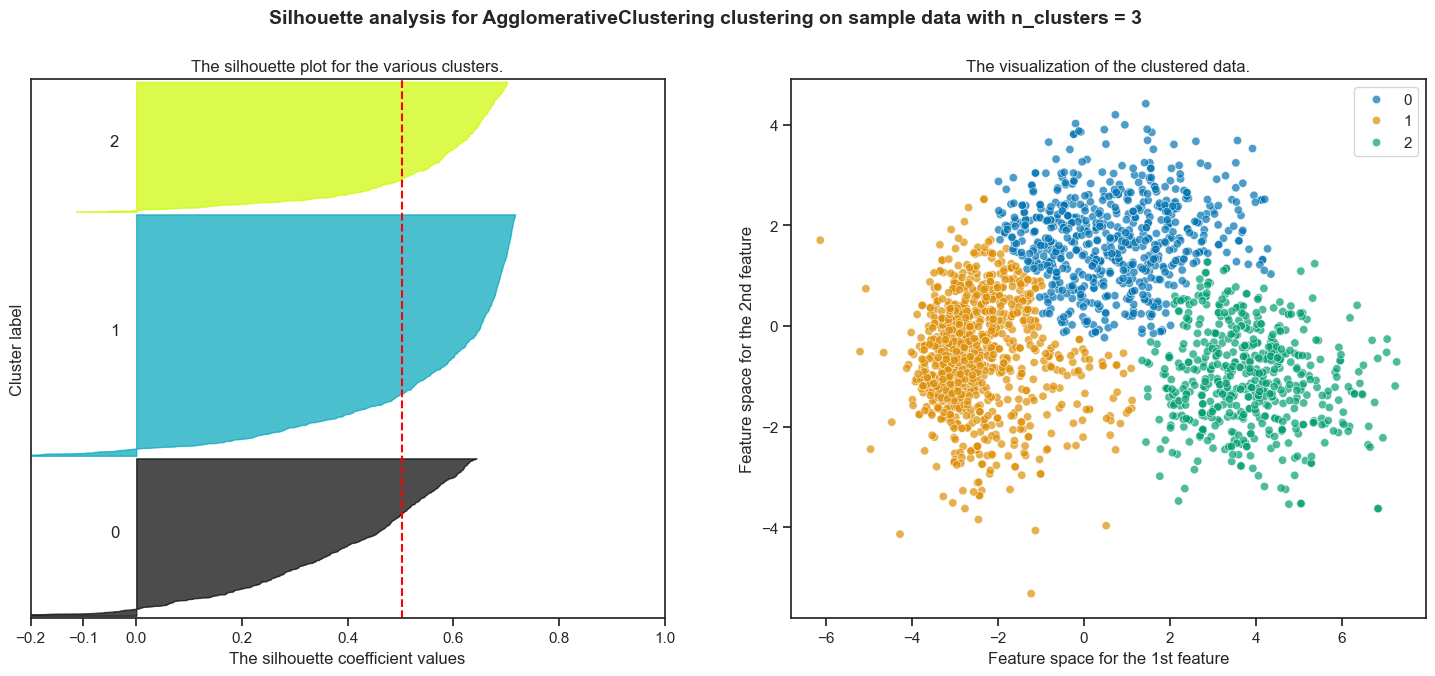

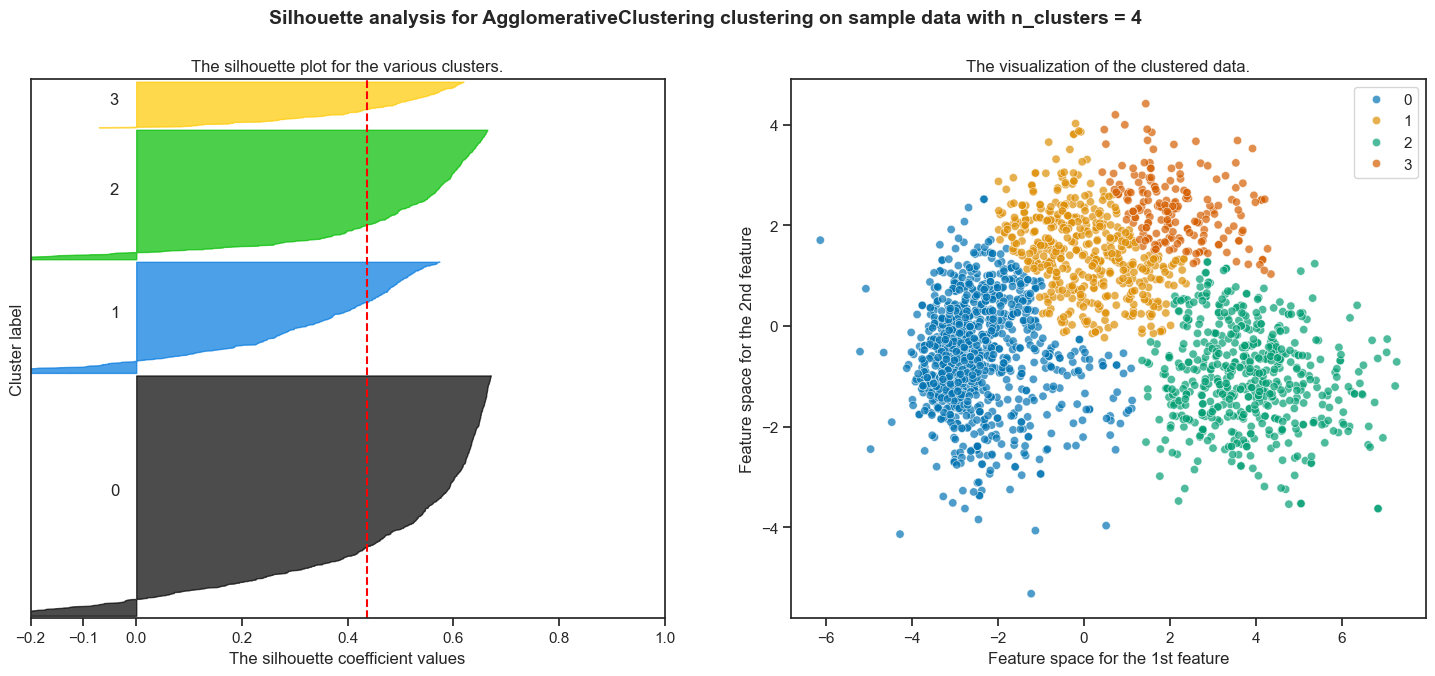

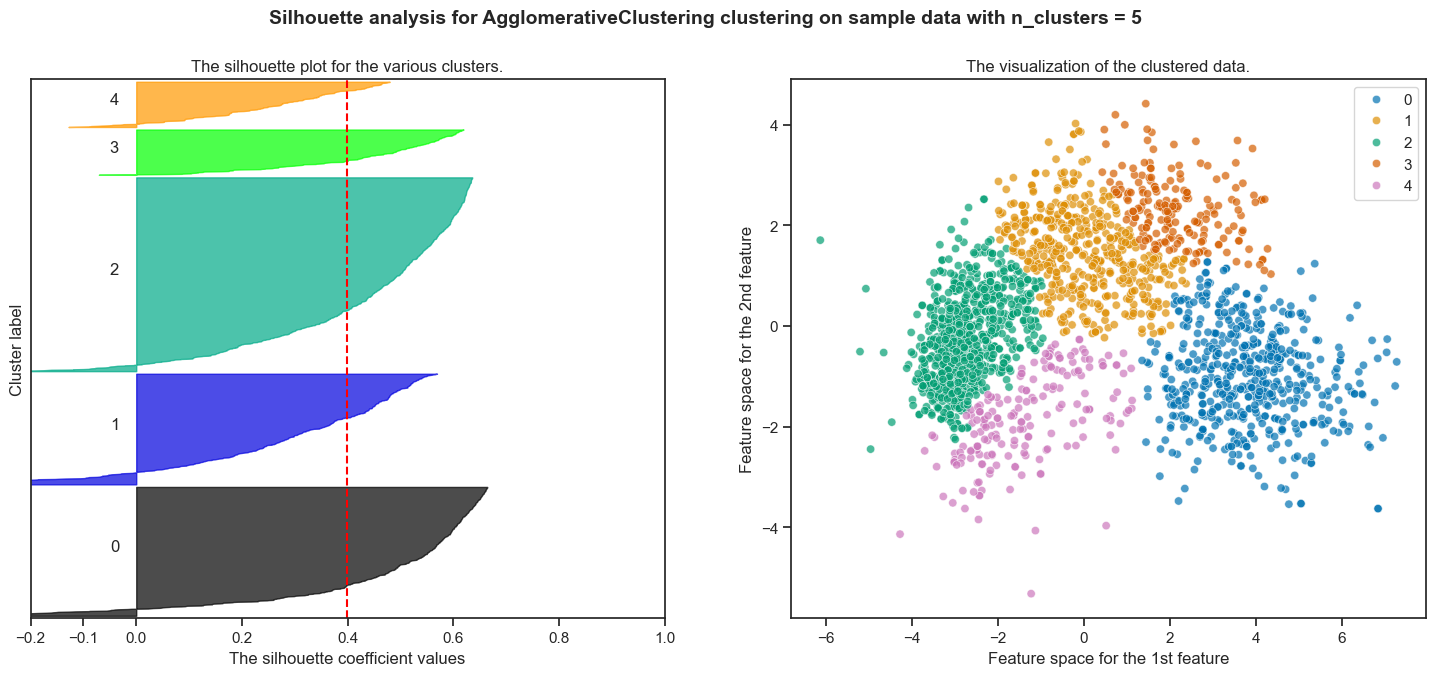

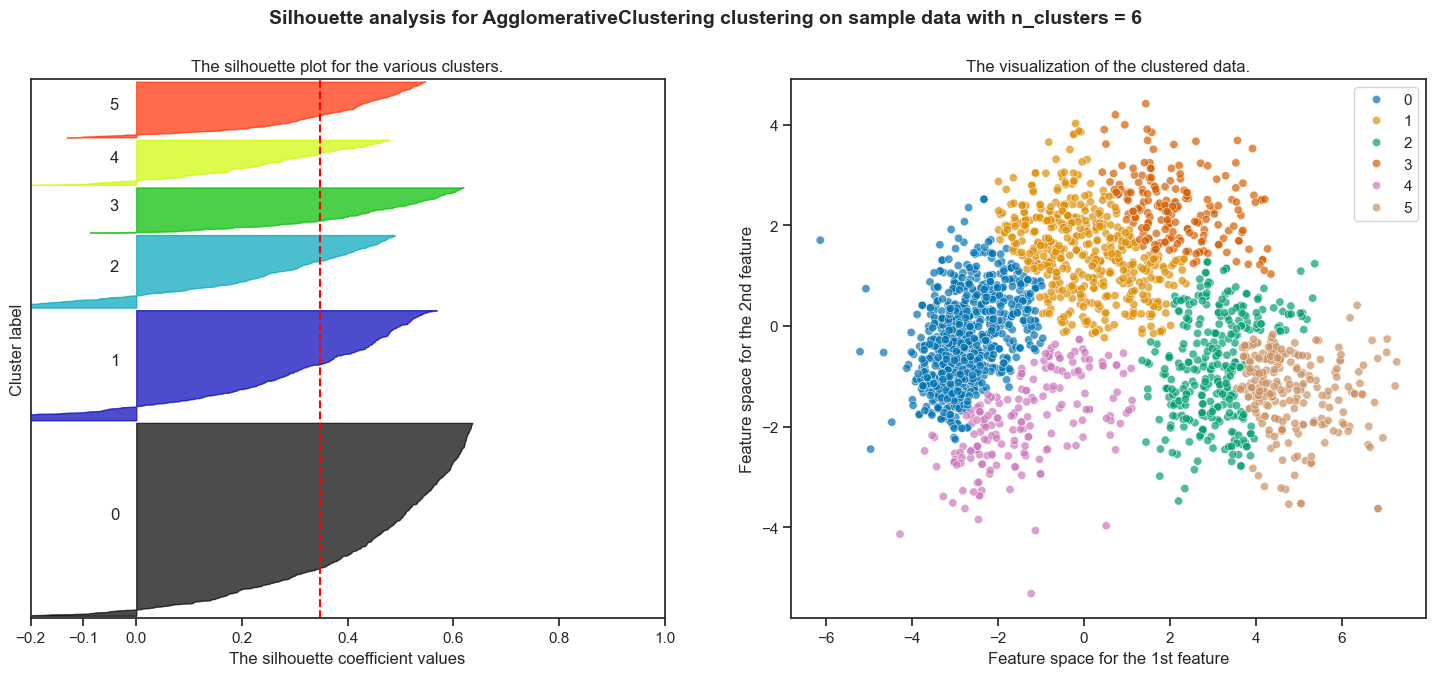

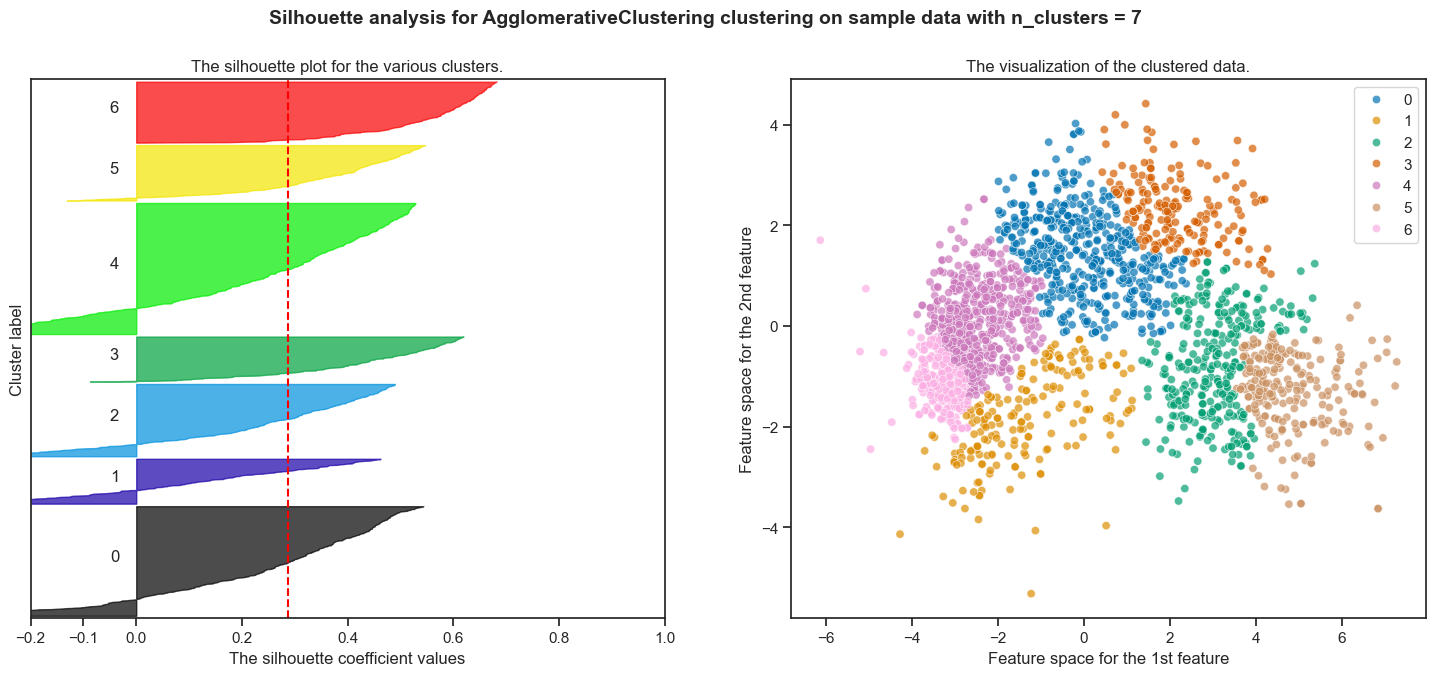

In [97]:
#Plot Score to choose best clusters
silhouette_plot(AgglomerativeClustering,range(3,8),pcadf,reduced)

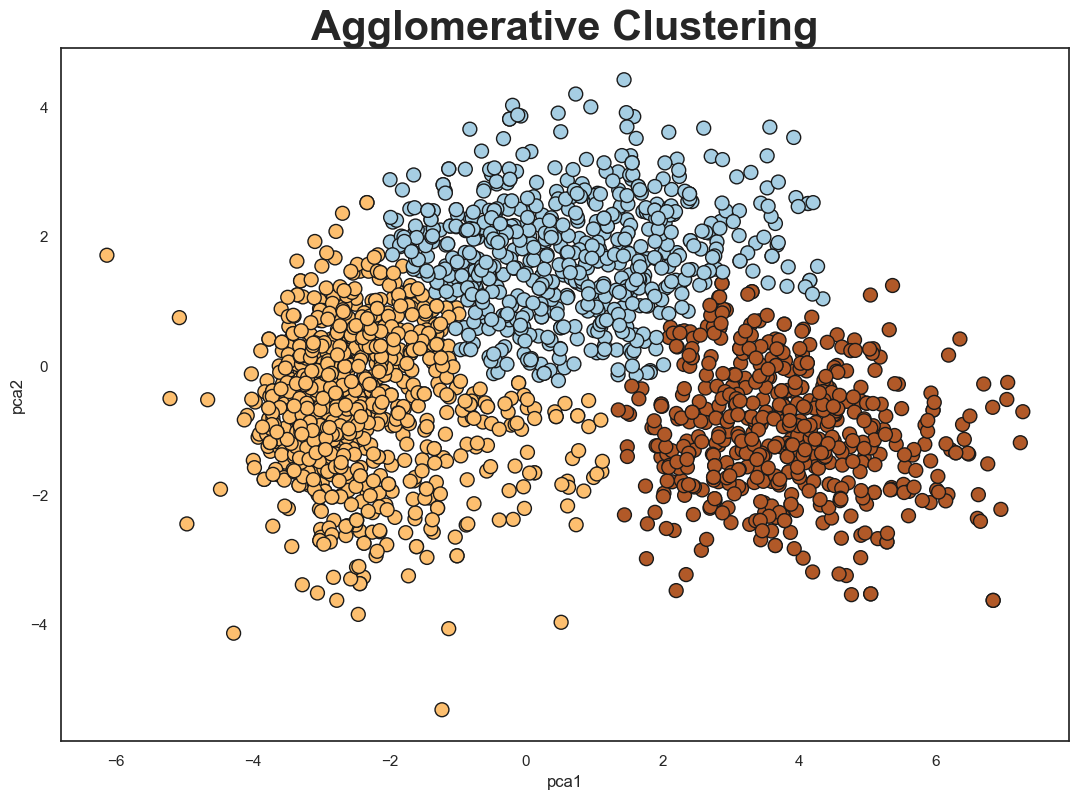

In [100]:
model = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(reduced,)
model_label = model.labels_
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Agglomerative Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='Paired', ec='k')

In [85]:
#save model labels as new feature
import os
df = data_eda.copy()
df["cluster"] = model.labels_.astype(int)
os.makedirs('data')
df.to_csv("./data/clustered_data.csv", index=False)

In [84]:
df.head()

education   income  recency  mnt_wines  mnt_fruits  mnt_meat_products  \
0          2  58138.0       58        635          88                546   
1          2  46344.0       38         11           1                  6   
2          2  71613.0       26        426          49                127   
3          2  26646.0       26         11           4                 20   
4          4  58293.0       94        173          43                118   

   mnt_fish_products  mnt_sweet_products  mnt_gold_prods  num_deals_purchases  \
0                172                  88              88                    3   
1                  2                   1               6                    2   
2                111                  21              42                    1   
3                 10                   3               5                    2   
4                 46                  27              15                    5   

   num_web_purchases  num_catalog_purchases  num_store_purchases  \
0                  8                     10                    4   
1                  1                      1                    2   
2                  8                      2                   10   
3                  2                      0                    4   
4                  5                      3                    6   

   num_web_visits_month  complain  response  age  family_size  total_spending  \
0                     7         0         1   67            1            1617   
1                     5         0         0   70            3              27   
2                     4         0         0   59            2             776   
3                     6         0         0   40            3              53   
4                     5         0         0   43            3             422   

   days_as_customer  offers_responded_to  parental_status  cluster  
0              4460                    1                0        0  
1              3910                    0                1        1  
2              4109                    0                0        0  
3              3936                    0                1        1  
4              3958                    0                1        2